In [ ]:
!pip install catboost
!pip install shap
!pip install imbalanced-learn==0.7.0
!pip install shap==0.40.0

In [ ]:
!gdown --id 148v6eFzlVw7jk0UO8iKkf-NuLdWeVCOS
!gdown --id 1mW1pOnj3-onH4BWTf1lUFRnxHEK9igB3
!gdown --id 1nWcK0chhZ3MZfPa2CrNlxBh7-LmG9WNU
!gdown --id 1L4fGZBSuC4aGmmtu9OVF-Ssun_iRlgZ2
!gdown --id 1X_joR52nx6TM6XN_zZ6WawszTnGyUGdl

In [1]:
# To supress warnings
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Basic Libraries for Data organization, Statistical operations and Plotting
import numpy as np
import pandas as pd
%matplotlib inline
# For loading .arff files
from scipy.io import arff
# To analyze the type of missing data
import missingno as msno
# To perform mean imputation
from sklearn.impute import SimpleImputer
# Perform KNN Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
#To perform kFold Cross Validation
from sklearn.model_selection import KFold
# Formatted counter of class labels
from collections import Counter
# Ordered Dictionary
from collections import OrderedDict
# Library imbalanced-learn to deal with the data imbalance. To use SMOTE oversampling
from imblearn.over_sampling import SMOTE 

# Impoting classification models
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

#importing misc
import random
import time
from collections import Counter

#importing graphic makers
import matplotlib.pyplot as plt
import seaborn as sns

#importing metric libraries
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import shap




In [2]:
############################################################
# Loads the 5 raw .arff files into a list
def load_arff_raw_data():
    N=5
    return [arff.loadarff(str(i+1) + 'year.arff') for i in range(N)]

# Loads the 5 raw .arff files into pandas dataframes
def load_dataframes():
    return [pd.DataFrame(data_i_year[0]) for data_i_year in load_arff_raw_data()]


# Set the column headers from X1 ... X64 and the class label as Y, for all the 5 dataframes.
def set_new_headers(dataframes):
    cols = ['X' + str(i+1) for i in range(len(dataframes[0].columns)-1)]
    cols.append('Y')
    for df in dataframes:
        df.columns = cols


# dataframes is the list of pandas dataframes for the 5 year datafiles.  
dataframes = load_dataframes()

# Set the new headers for the dataframes. The new headers will have the renamed set of feature (X1 to X64)
set_new_headers(dataframes)    

# print the first 5 rows of a dataset 'year1'
dataframes[0].head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,Y
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,b'0'
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,b'0'
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,b'0'
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,b'0'
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,b'0'


In [3]:
# Convert the dtypes of all the columns (other than the class label columns) to float.
def convert_columns_type_float(dfs):
    for i in range(5):
        index = 1
        while(index<=63):
            colname = dfs[i].columns[index]
            col = getattr(dfs[i], colname)
            dfs[i][colname] = col.astype(float)
            index+=1
            
convert_columns_type_float(dataframes)

In [4]:
# The class labels for all the dataframes are originally in object type.
# Convert them to int types
def convert_class_label_type_int(dfs):
    for i in range(len(dfs)):
        col = getattr(dfs[i], 'Y')
        dfs[i]['Y'] = col.astype(int)
        
convert_class_label_type_int(dataframes)

In [5]:
#calculate correlation and convert to csv
def calc_corr(dfs):
    for i, df in enumerate(dfs):
        df.corr().to_csv(f'./{i+1}_year_corr.csv')

calc_corr(dataframes)

In [6]:
# concat the dataframes first so that the features dropped for all files are the same
concat_dataframes = pd.concat(dataframes)
concat_dataframes
#loop the drop of the features
def drop_corr_features(dfs):
    for i,df in enumerate(dfs):
        cor_matrix = concat_dataframes.corr().abs()
        upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
        
        #drop redundant features with more than 95% correlation
        to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
        dataframes[i] = df.drop(to_drop, axis=1)
    
drop_corr_features(dataframes)

#check if all is the same
print(dataframes[0].shape)
print(dataframes[1].shape)
print(dataframes[2].shape)
print(dataframes[3].shape)
print(dataframes[4].shape)

(7027, 44)
(10173, 44)
(10503, 44)
(9792, 44)
(5910, 44)


In [8]:
# Get Clean dataframes by dropping all the rows which have missing values
def drop_nan_rows(dataframes, verbose=False):
    clean_dataframes = [df.dropna(axis=0, how='any') for df in dataframes]
    if verbose:
        for i in range(len(dataframes)):
            print(str(i+1)+'year:','Original Length=', len(dataframes[i]), '\tCleaned Length=', len(clean_dataframes[i]), '\tMissing Data=', len(dataframes[i])-len(clean_dataframes[i]))
    return clean_dataframes

# Doing a quick analysis of how many missing values are there in each of the 5 dataframes
nan_dropped_dataframes = drop_nan_rows(dataframes, verbose=True)

1year: Original Length= 7027 	Cleaned Length= 3195 	Missing Data= 3832
2year: Original Length= 10173 	Cleaned Length= 4088 	Missing Data= 6085
3year: Original Length= 10503 	Cleaned Length= 4885 	Missing Data= 5618
4year: Original Length= 9792 	Cleaned Length= 4769 	Missing Data= 5023
5year: Original Length= 5910 	Cleaned Length= 3031 	Missing Data= 2879


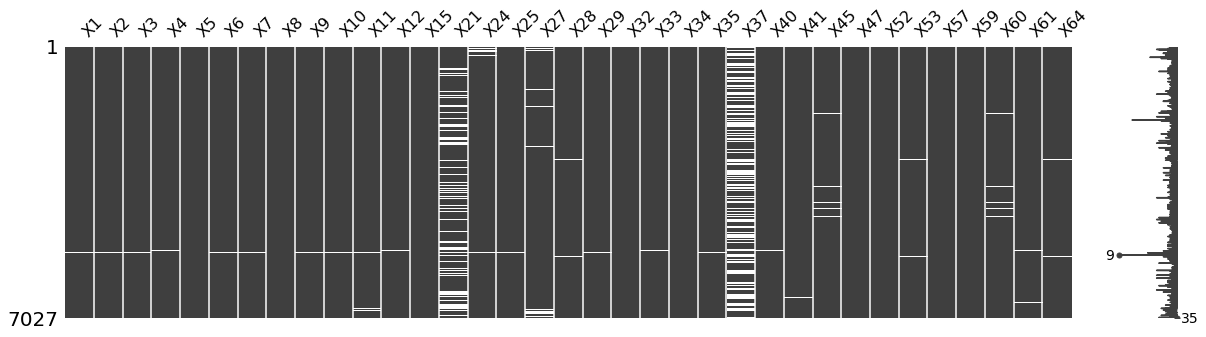

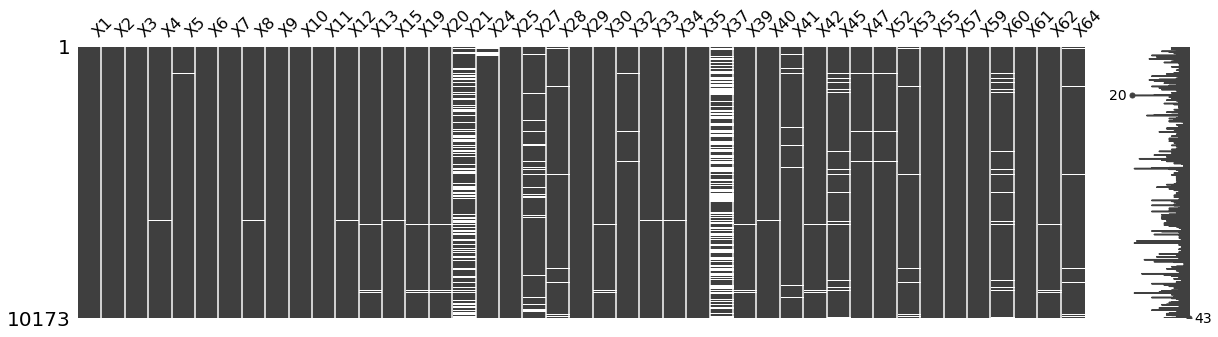

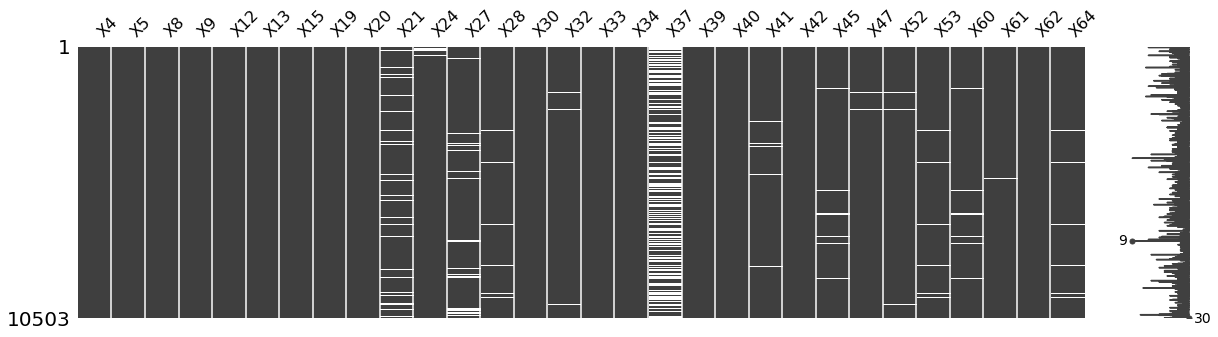

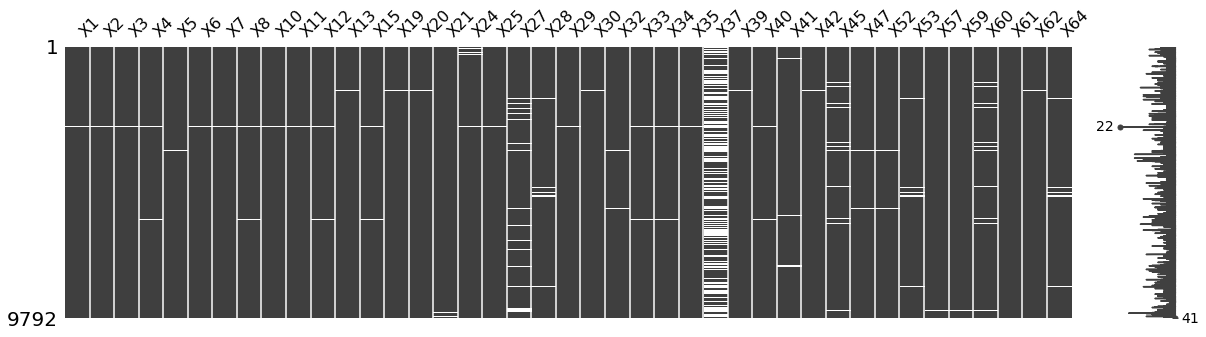

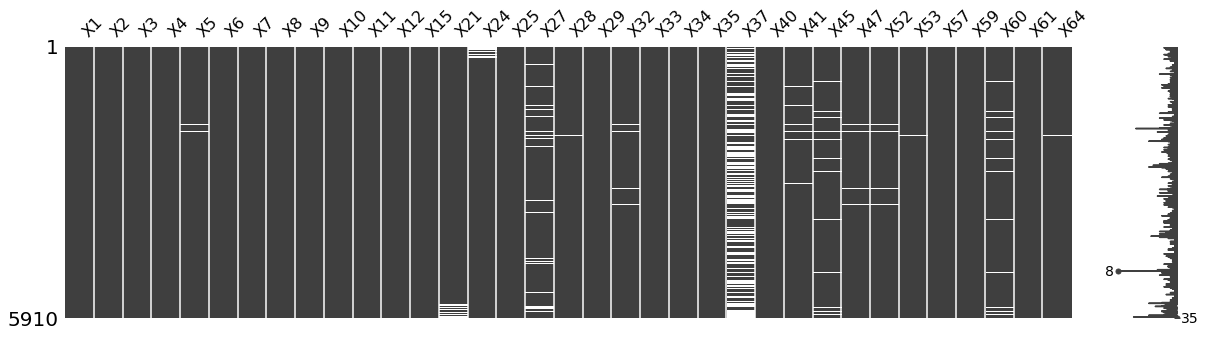

In [9]:
# generate the sparsity matrix (figure) for all the dataframes
def generate_sparsity_matrix(dfs):
    for i in range(5):
        missing_df_i = dfs[i].columns[dfs[i].isnull().any()].tolist()
        msno.matrix(dfs[i][missing_df_i], figsize=(20,5))

generate_sparsity_matrix(dataframes)

In [10]:
from sklearn.model_selection import train_test_split
def split_dataframes(dfs, **kwargs):
    train_dfs = []
    test_dfs = []
    for df in dfs:
        #maintain data integrity of Target Class
        train_df, test_df = train_test_split(df, **kwargs, stratify=df['Y'])
        train_dfs.append(train_df)
        test_dfs.append(test_df)
    return train_dfs, test_dfs

In [11]:
dataframes_train, dataframes_test = split_dataframes(dataframes, test_size=.15, random_state=42)

In [12]:
def perform_mean_imputation(dfs_train, dfs_test):
    # Construct an imputer with strategy as 'mean', to mean-impute along the columns
    mean_imputed_dfs_train = []
    mean_imputed_dfs_test = []
    for df_train, df_test in zip(dfs_train, dfs_test):
        imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
        imputer.fit(df_train)
        mean_imputed_dfs_train.append(pd.DataFrame(imputer.transform(df_train)))
        mean_imputed_dfs_test.append(pd.DataFrame(imputer.transform(df_test)))

    for i in range(len(dfs_train)):
        mean_imputed_dfs_train[i].columns = dfs_train[i].columns  
        mean_imputed_dfs_test[i].columns = dfs_test[i].columns
    return mean_imputed_dfs_train, mean_imputed_dfs_test

imputed_dataframes_dictionary_train = OrderedDict()
imputed_dataframes_dictionary_test = OrderedDict()
imputed_dataframes_dictionary_train['Mean'], imputed_dataframes_dictionary_test['Mean'] = perform_mean_imputation(dataframes_train, dataframes_test)

In [13]:
def check_data_imbalance(dfs):
    for i in range(len(dfs)):
        print('Dataset: '+str(i+1)+'year')
        print(dfs[i].groupby('Y').size())
        minority_percent = (dfs[i]['Y'].tolist().count(1) / len(dfs[i]['Y'].tolist()))*100
        print('Minority (label 1) percentage: '+  str(minority_percent) + '%')
        print('-'*64)
        
check_data_imbalance(dataframes)

Dataset: 1year
Y
0    6756
1     271
dtype: int64
Minority (label 1) percentage: 3.856553294435748%
----------------------------------------------------------------
Dataset: 2year
Y
0    9773
1     400
dtype: int64
Minority (label 1) percentage: 3.931976801336872%
----------------------------------------------------------------
Dataset: 3year
Y
0    10008
1      495
dtype: int64
Minority (label 1) percentage: 4.712939160239932%
----------------------------------------------------------------
Dataset: 4year
Y
0    9277
1     515
dtype: int64
Minority (label 1) percentage: 5.259395424836601%
----------------------------------------------------------------
Dataset: 5year
Y
0    5500
1     410
dtype: int64
Minority (label 1) percentage: 6.937394247038917%
----------------------------------------------------------------


In [14]:
# Split the features and labels into separate dataframes for all the original dataframes
column_length = dataframes[0].shape[1]-1

def split_dataframes_features_labels(dfs):
    feature_dfs = [dfs[i].iloc[:,0:column_length] for i in range(len(dfs))]
    label_dfs = [dfs[i].iloc[:,column_length] for i in range(len(dfs))]
    return feature_dfs, label_dfs

# Performs the SMOTE oversampling for given dataframes.
def oversample_data_SMOTE(dfs, verbose=False):
    smote = SMOTE(sampling_strategy='auto' , random_state=42, k_neighbors=10)
    #Split the features and labels for each dataframe
    feature_dfs, label_dfs = split_dataframes_features_labels(dfs)
    resampled_feature_arrays = []
    resampled_label_arrays = []
    for i in range(len(dfs)):
        if verbose: print('Dataset: ' + str(i+1) + 'year:')
        if verbose: print('Original dataset shape {}'.format(Counter(label_dfs[i])))
        dfi_features_res, dfi_label_res = smote.fit_sample(feature_dfs[i], label_dfs[i])
        if verbose: print('Resampled dataset shape {}\n'.format(Counter(dfi_label_res)))
        # Append the resampled feature and label arrays of ith dataframe to their respective list of arrays    
        resampled_feature_arrays.append(dfi_features_res)
        resampled_label_arrays.append(dfi_label_res)        
    return resampled_feature_arrays, resampled_label_arrays

# Utility Function to convert the arrays of features and labels to pandas dataframes, and then join them.
# Also re-assign the columns headers.
def restructure_arrays_to_dataframes(feature_arrays, label_arrays):
    resampled_dfs = []
    for i in range(len(feature_arrays)):
        feature_df = pd.DataFrame(data=feature_arrays[i])
        label_df = pd.DataFrame(data=label_arrays[i])
        # Must set the column header for label_df, otherwise it wont join with feature_df, as columns overlap (with col names '0')
        label_df.columns=['Y'] 
        resampled_dfs.append(feature_df.join(label_df))
    # re-assign the column headers for features and labels    
    set_new_headers(resampled_dfs)    
    return resampled_dfs

# Perform SMOTE oversampling on all the imputed dataframes, and return them in a dictionary.
def perform_oversampling_on_imputed_dataframes(df_dict):
    imputed_oversampled_dataframes_dictionary = OrderedDict()
    for key,dfs in df_dict.items():
        print('SMOTE Oversampling for ' + key + ' imputed dataframes\n')
        smote_feature_arrays, smote_label_arrays = oversample_data_SMOTE(dfs, verbose=True)
        oversampled_dataframes = restructure_arrays_to_dataframes(smote_feature_arrays, smote_label_arrays)
        imputed_oversampled_dataframes_dictionary[key] = oversampled_dataframes
        print('-'*100)
    return imputed_oversampled_dataframes_dictionary

# imputed_oversampled_dataframes_dictionary = perform_oversampling_on_imputed_dataframes(imputed_dataframes_dictionary)
imputed_oversampled_dataframes_dictionary = perform_oversampling_on_imputed_dataframes(imputed_dataframes_dictionary_train)

SMOTE Oversampling for Mean imputed dataframes

Dataset: 1year:
Original dataset shape Counter({0.0: 5742, 1.0: 230})
Resampled dataset shape Counter({0.0: 5742, 1.0: 5742})

Dataset: 2year:
Original dataset shape Counter({0.0: 8307, 1.0: 340})
Resampled dataset shape Counter({0.0: 8307, 1.0: 8307})

Dataset: 3year:
Original dataset shape Counter({0.0: 8506, 1.0: 421})
Resampled dataset shape Counter({0.0: 8506, 1.0: 8506})

Dataset: 4year:
Original dataset shape Counter({0.0: 7885, 1.0: 438})
Resampled dataset shape Counter({0.0: 7885, 1.0: 7885})

Dataset: 5year:
Original dataset shape Counter({0.0: 4675, 1.0: 348})
Resampled dataset shape Counter({0.0: 4675, 1.0: 4675})

----------------------------------------------------------------------------------------------------


In [15]:
def prepare_kfold_cv_data(k, X, y, verbose=False):
    X = X.values
    y = y.values
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    
    for train_index, test_index in kf.split(X):
        X_train.append(X[train_index])
        y_train.append(y[train_index])
        X_test.append(X[test_index])
        y_test.append(y[test_index])
    return X_train, y_train, X_test, y_test

In [16]:

# add model
lr_classifier = LogisticRegression(penalty = 'l2')

xgb_classifier = XGBClassifier(eval_metric ="logloss")

rf_classifier = RandomForestClassifier(n_estimators = 50, criterion = 'entropy', min_samples_leaf = 50)

adab_classifier = AdaBoostClassifier( learning_rate=0.1)

cb_classifier = CatBoostClassifier(verbose=0, iterations=10)

lgbm_classifier = LGBMClassifier(learning_rate = 0.1)

In [17]:
# add model
models_dictionary = OrderedDict()

models_dictionary['LR'] = lr_classifier
models_dictionary['AdaBoost'] = adab_classifier
models_dictionary['XGB'] = xgb_classifier
models_dictionary['CatBoost'] = cb_classifier
models_dictionary['LGBM'] = lgbm_classifier
models_dictionary['RF'] = rf_classifier

In [18]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D, AveragePooling1D
from tensorflow import keras
from tensorflow.keras import regularizers

bias_initializer = tf.keras.initializers.lecun_normal
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=128, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4),
    activity_regularizer=regularizers.l2(1e-5), kernel_size=2, input_shape=(43, 1), name = 'cnn1'))
model_cnn.add(AveragePooling1D(name='pool1'))
model_cnn.add(Flatten())
model_cnn.add(Dense(units=256, activation='selu', name = 'fc1', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4),
    activity_regularizer=regularizers.l2(1e-5), use_bias = True, bias_initializer= bias_initializer ))
model_cnn.add(Dropout(.3))
model_cnn.add(Dense(units=128, activation='selu', name = 'fc2', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4),
    activity_regularizer=regularizers.l2(1e-5), use_bias = True, bias_initializer= bias_initializer ))
model_cnn.add(Dropout(.3))
model_cnn.add(Dense(units=1, activation='sigmoid', name = 'fc3',  kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4),
    activity_regularizer=regularizers.l2(1e-5), use_bias = True, bias_initializer= 'zeros' ))

model_cnn.summary()

opt = keras.optimizers.Adadelta(learning_rate=1e-2)
model_cnn.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model_cnn.save_weights('./model_init_CNN.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cnn1 (Conv1D)                (None, 42, 128)           384       
_________________________________________________________________
pool1 (AveragePooling1D)     (None, 21, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 2688)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 256)               688384    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
fc2 (Dense)                  (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [19]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D, AveragePooling1D
from tensorflow import keras
from tensorflow.keras import regularizers

model_ann = Sequential()
model_ann.add(Dense(units=256, name = 'fc1', input_shape=(43, ),
    use_bias = True, activation='selu'))
model_ann.add(Dropout(.3))
model_ann.add(Dense(units=128, name = 'fc2', use_bias = True, activation='selu'))
model_ann.add(Dropout(.3))
model_ann.add(Dense(units=1, activation='sigmoid', name = 'fc3', use_bias = True))

model_ann.summary()
opt = keras.optimizers.RMSprop(learning_rate=1e-3)
model_ann.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model_ann.save_weights('./model_init_ANN.h5')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 256)               11264     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
fc2 (Dense)                  (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
fc3 (Dense)                  (None, 1)                 129       
Total params: 44,289
Trainable params: 44,289
Non-trainable params: 0
_________________________________________________________________


In [20]:
models_dictionary_dl = OrderedDict()
models_dictionary_dl['CNN'] = model_cnn
models_dictionary_dl['ANN'] = model_ann

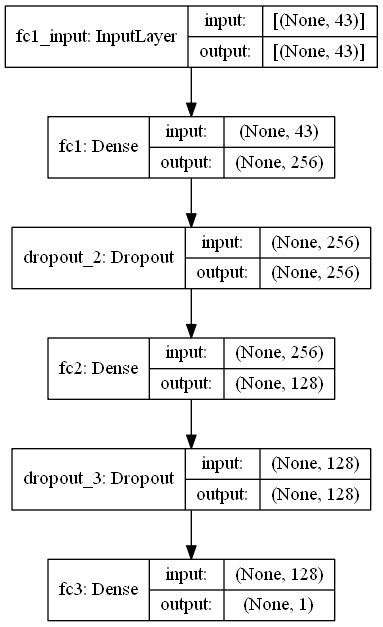

In [21]:
from tensorflow.keras.utils import plot_model
plot_model(model_ann,
           to_file="model_ann.png",
           show_shapes=True,
           show_layer_names=True,
          )

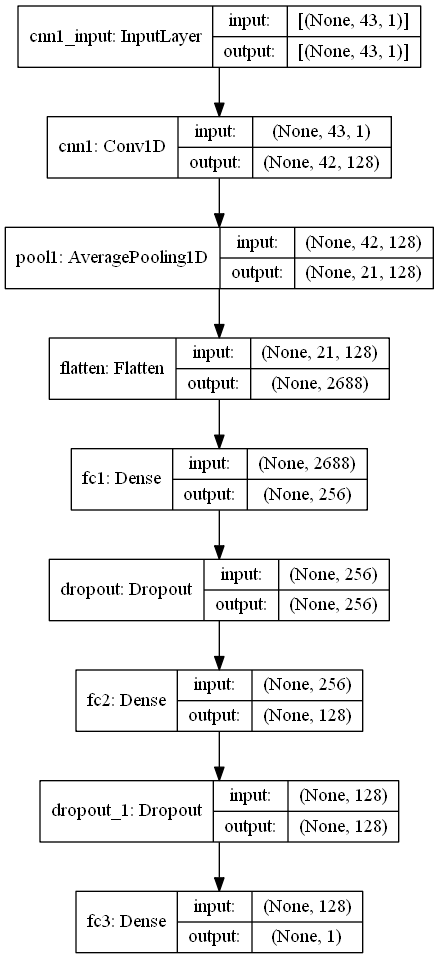

In [22]:
plot_model(model_cnn,
           to_file="model_cnn.png",
           show_shapes=True,
           show_layer_names=True,
          )

In [ ]:
_imputers_test_ = imputed_dataframes_dictionary_test


feature_dfs_loo, label_dfs_loo = split_dataframes_features_labels(_imputers_test_[imputer_name])

In [ ]:
from tqdm.notebook import tqdm
def perform_data_modeling_dl(_models_, _imputers_, _imputers_test_, model_names=[], verbose=False, k_folds=5):
    
    model_results = OrderedDict()
    
    # Iterate over the models
    if not model_names:
        model_names = [model_name for model_name in _models_.keys()]
    for model_name in model_names:
        clf = _models_[model_name]
        if verbose: print("-"*120, "\n", "Model: " + '\033[1m' + model_name + '\033[0m' + " Classifier")
        imputer_results = OrderedDict()
        
        # Iterate over the imputed_data 
        for imputer_name, dataframes_list in _imputers_.items():
            if verbose: print('\tImputer Technique: ' + '\033[1m' + imputer_name + '\033[0m')
            
            # call the split_dataframes_features_labels function to get a list of features and labels for all the dataframes
            feature_dfs, label_dfs = split_dataframes_features_labels(dataframes_list)            
            
            year_results = OrderedDict()
            
            #early stopper
            callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

            # Iterate over dataframe_list individually
            for df_index in range(len(dataframes_list)):
                if verbose: print('\t\tDataset: ' + '\033[1m' + str(df_index+1) + 'year' + '\033[0m')
                
                # Calling the 'prepare_kfold_cv_data' returns lists of features and labels 
                # for train and test sets respectively.
                # The number of items in the list is equal to k_folds
                X_train_list, y_train_list, X_test_list, y_test_list = prepare_kfold_cv_data(k_folds, feature_dfs[df_index], label_dfs[df_index], verbose)
                
                # hold out sample
                feature_dfs_loo, label_dfs_loo = split_dataframes_features_labels(_imputers_test_[imputer_name])
                X_loo = feature_dfs_loo[df_index].values
                y_loo = label_dfs_loo[df_index].values
                

                metrics_results = OrderedDict()
                accuracy_list = []
                accuracy_list_loo = []
                precision_list = []
                recall_list = []
                TN_list = []
                FP_list = []
                FN_list = []
                TP_list = []
                ns_auc_list = []
                auc_list = []
                auc_list_loo = []
                cm_list =  []
                cm_list_loo = []
                train_time_list = []
                y_loo_proba_list = []

                for k_index in tqdm(range(k_folds)):

                    clf.load_weights(f'./model_init_{model_name}.h5')
                    X_train = X_train_list[k_index]
                    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
                    y_train = y_train_list[k_index]
                    X_test = X_test_list[k_index]
                    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
                    y_test = y_test_list[k_index]

                    start_time = time.time()
                    history = clf.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[callback], verbose=0)
                    end_time = time.time()
                    
                    y_test_predicted_proba = clf.predict(X_test)
                    y_test_predicted = np.where(y_test_predicted_proba >= 0.5, 1, 0)[:, 0]
                    y_loo_predicted_proba = clf.predict(X_loo)
                    y_loo_predicted = np.where(y_loo_predicted_proba >= 0.5, 1, 0)[:, 0]
                    y_loo_proba_list.append(y_loo_predicted_proba)

                    _accuracy_ = accuracy_score(y_test, y_test_predicted, normalize=True)
                    accuracy_list.append(_accuracy_)
                    _accuracy_loo_ = accuracy_score(y_loo, y_loo_predicted, normalize=True)
                    accuracy_list_loo.append(_accuracy_loo_)

                    _precision_ = precision_score(y_test, y_test_predicted, average=None)
                    precision_list.append(_precision_)
                    _recall_ = recall_score(y_test, y_test_predicted, average=None)
                    recall_list.append(_recall_)

                    _confusion_matrix_ = confusion_matrix(y_test, y_test_predicted)
                    cm_list.append(_confusion_matrix_)
                    TN_list.append(_confusion_matrix_[0][0])
                    FP_list.append(_confusion_matrix_[0][1])
                    FN_list.append(_confusion_matrix_[1][0])
                    TP_list.append(_confusion_matrix_[1][1])
                    _confusion_matrix_loo_ = confusion_matrix(y_loo, y_loo_predicted)
                    cm_list_loo.append(_confusion_matrix_loo_)

                    train_time_list.append(end_time - start_time)

                    ns_probs = np.random.randint(2, size=len(y_test))
                    ns_auc = roc_auc_score(y_test, ns_probs)
                    clf_auc = roc_auc_score(y_test, y_test_predicted_proba)
                    clf_auc_loo = roc_auc_score(y_loo, y_loo_predicted_proba)
                    ns_auc_list.append(ns_auc)
                    auc_list.append(clf_auc)
                    auc_list_loo.append(clf_auc_loo)

                metrics_results['Accuracy'] = np.mean(accuracy_list)
                metrics_results['Accuracy_LOO'] = accuracy_list_loo
                metrics_results['Precisions'] = np.mean(precision_list, axis=0)
                metrics_results['Recalls'] = np.mean(recall_list, axis=0)
                metrics_results['TN'] = np.mean(TN_list)
                metrics_results['FP'] = np.mean(FP_list)
                metrics_results['FN'] = np.mean(FN_list)
                metrics_results['TP'] = np.mean(TP_list)
                metrics_results['NS_AUC'] = np.mean(ns_auc)
                metrics_results['AUC'] = np.mean(auc_list)
                metrics_results['AUC_LOO'] = auc_list_loo
                metrics_results['CM'] = np.mean(cm_list, axis=0)
                metrics_results['CM_LOO'] = np.mean(cm_list_loo, axis=0)

                y_loo_predicted_proba_mean = np.mean(y_loo_proba_list, axis=0)[:, 0]
                fpr, tpr, thresholds = roc_curve(y_loo, y_loo_predicted_proba_mean)
                gmeans = np.sqrt(tpr * (1-fpr))
                ix = np.argmax(gmeans)
                metrics_results['threshold'] = thresholds[ix]
                _confusion_matrix_loo_default_ = confusion_matrix(y_loo, np.where(y_loo_predicted_proba_mean>=.5, 1, 0))
                _confusion_matrix_loo_best_ = confusion_matrix(y_loo, np.where(y_loo_predicted_proba_mean>=thresholds[ix], 1, 0))
                _confusion_matrix_loo_custom_ = confusion_matrix(y_loo, np.where(y_loo_predicted_proba_mean>=.3, 1, 0))
                metrics_results['CM_LOO_DEFAULT'] = _confusion_matrix_loo_default_
                metrics_results['CM_LOO_BEST'] = _confusion_matrix_loo_best_
                metrics_results['CM_LOO_CUSTOM'] = _confusion_matrix_loo_custom_
                metrics_results['train_time'] = train_time_list

                if verbose:
                    print('\t\t\tAccuracy:', metrics_results['Accuracy'])
                    print('\t\t\tPrecision:', metrics_results['Precisions'])
                    print('\t\t\tRecall:', metrics_results['Recalls'])
                    print('\t\t\tNS_AUC:', metrics_results['NS_AUC'])
                    print('\t\t\tAUC:', metrics_results['AUC'])
                    print('\t\t\tBest Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

                year_results[str(df_index+1)+'year'] = metrics_results   
                
            imputer_results[imputer_name] = year_results
            
        model_results[model_name] = imputer_results  
        
    return model_results

In [ ]:
results_dl = perform_data_modeling_dl(models_dictionary_dl, tmp, imputed_dataframes_dictionary_test, model_names=['ANN', 'CNN'], verbose=True, k_folds=5)

In [ ]:
results_dl['CNN']['Mean']

In [ ]:
results_dl['ANN']['Mean']

In [28]:
# perform data modeling for non DL Models
def perform_data_modeling(_models_, _imputers_, _imputers_test_, calc_shap=True, model_names=[], verbose=False, k_folds=5):
    
    model_results = OrderedDict()
    
    # Iterate over the models
    if not model_names:
        model_names = [model_name for model_name in _models_.keys()]
    for model_name in model_names:
        clf = _models_[model_name]
        if verbose: print("-"*120, "\n", "Model: " + '\033[1m' + model_name + '\033[0m' + " Classifier")
        imputer_results = OrderedDict()
        
        # Iterate over the different imputed_data mechanisms
        for imputer_name, dataframes_list in _imputers_.items():
            if verbose: print('\tImputer Technique: ' + '\033[1m' + imputer_name + '\033[0m')
            
            # call the split_dataframes_features_labels function to get a list of features and labels for all the dataframes
            feature_dfs, label_dfs = split_dataframes_features_labels(dataframes_list)            
            year_results = OrderedDict()
            
                        
            # Iterate over dataframe_list individually
            for df_index in range(len(dataframes_list)):
                if verbose: print('\t\tDataset: ' + '\033[1m' + str(df_index+1) + 'year' + '\033[0m')
                
                # Calling the 'prepare_kfold_cv_data' returns lists of features and labels 
                # for train and test sets respectively.
                # The number of items in the list is equal to k_folds
                X_train_list, y_train_list, X_test_list, y_test_list = prepare_kfold_cv_data(k_folds, feature_dfs[df_index], label_dfs[df_index], verbose)
                
                
                # hold out sample, we access the original dataframe list which are different from the train and test set
                feature_dfs_loo, label_dfs_loo = split_dataframes_features_labels(_imputers_test_[imputer_name])
                X_loo = feature_dfs_loo[df_index].values
                y_loo = label_dfs_loo[df_index].values
                
                #LOO Set Checker
                c = Counter(y_loo)
                print([(i, c[i] / len(y_loo) * 100.0) for i in c])
                print(c)
                
                metrics_results = OrderedDict()
                accuracy_list = np.zeros([k_folds])
                accuracy_list_loo = []
                precision_list = np.zeros([k_folds,2])
                precision_list_loo = np.zeros([k_folds,2])
                recall_list = np.zeros([k_folds,2])
                recall_list_loo= np.zeros([k_folds,2])
                f1_list = np.zeros([k_folds,2])
                f1_list_loo = []
                TN_list = np.zeros([k_folds])
                FP_list = np.zeros([k_folds])
                FN_list = np.zeros([k_folds])
                TP_list = np.zeros([k_folds])
                ns_auc_list = np.zeros([k_folds])
                auc_list = np.zeros([k_folds])
                auc_list_loo = []
                cm_list = []
                cm_list_loo = []

                y_loo_proba_list = []
                
                feature_importance_df = pd.DataFrame()
                train_time_list = np.zeros([k_folds])
                
                shap_values_list = []
                expected_value_list = []

                # Iterate over all the k-folds
                for k_index in range(k_folds):
                    X_train = X_train_list[k_index]
                    y_train = y_train_list[k_index]
                    X_test = X_test_list[k_index]
                    y_test = y_test_list[k_index]
                    X_full = np.concatenate([X_train, X_test])
                    y_full = np.concatenate([y_train, y_test])

                    #begin train time
                    start_time = time.time()
                    # Fit the model and predict using test as well as LOO sets
                    clf.fit(X_train, y_train)
                    end_time = time.time()
                    
                    #Predict using populated
                    y_test_predicted = clf.predict(X_test)
                    #Predict using non populated
                    y_loo_predicted = clf.predict(X_loo)
                                      
                    
                    #calc feats importance
                    if model_name not in ['LR', 'SVM'] and calc_shap:
                        #calc shap values
                        if model_name in ['LGBM', 'XGB', 'CatBoost', 'RF']:
                            explainer = shap.TreeExplainer(clf, model_output='probability', data=X_train)
                            if model_name in ['LGBM', 'XGB', 'CatBoost']:
                                shap_values = explainer.shap_values(X_full)
                                expected_value = explainer.expected_value
                            elif model_name in ['RF']:
                                shap_values = explainer.shap_values(X_full)[1]
                                expected_value = explainer.expected_value[1]
                        elif model_name in ['AdaBoost']:
                            shap_values = np.zeros(X_full.shape)
                            expected_value = 0
                        shap_values_list.append(shap_values)
                        expected_value_list.append(expected_value)
                        
                        fold_importance_df = pd.DataFrame()
                        fold_importance_df['feature'] = feature_dfs[df_index].columns
                        fold_importance_df['importance'] = clf.feature_importances_
                        fold_importance_df['shap_values'] = abs(shap_values).mean(axis=0)
                        fold_importance_df['fold'] = k_index+1
                        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
                    
                    #code for calculating accuracy 
                    _accuracy_ = accuracy_score(y_test, y_test_predicted, normalize=True)
                    accuracy_list[k_index] = _accuracy_
                    _accuracy_loo_ = accuracy_score(y_loo, y_loo_predicted, normalize=True)
                    accuracy_list_loo.append(_accuracy_loo_)
                                      
                    #code for calculating recall 
                    _recalls_ = recall_score(y_test, y_test_predicted, average=None)
                    recall_list[k_index] = _recalls_
                    _recalls_loo_ = recall_score(y_loo, y_loo_predicted, average=None)
                    recall_list_loo[k_index] = _recalls_
                    
                    #code for calculating precision 
                    _precisions_ = precision_score(y_test, y_test_predicted, average=None)
                    precision_list[k_index] = _precisions_
                    _precisions_loo_ = precision_score(y_loo, y_loo_predicted, average=None)
                    precision_list_loo[k_index] = _precisions_
                    
                    
                    #code for calculating f1-score
                    _f1_ = f1_score(y_test, y_test_predicted, average = None)
                    f1_list[k_index] = _f1_
                    _f1_loo_ = f1_score(y_loo, y_loo_predicted, average = None)
                    f1_list_loo.append(_f1_loo_)
                    
                    #code for calculating confusion matrix 
                    _confusion_matrix_ = confusion_matrix(y_test, y_test_predicted)
                    cm_list.append(_confusion_matrix_)
                    TN_list[k_index] = _confusion_matrix_[0][0]
                    FP_list[k_index] = _confusion_matrix_[0][1]
                    FN_list[k_index] = _confusion_matrix_[1][0]
                    TP_list[k_index] = _confusion_matrix_[1][1]
                    _confusion_matrix_loo_ = confusion_matrix(y_loo, y_loo_predicted)
                    cm_list_loo.append(_confusion_matrix_loo_)
                    
                    train_time_list[k_index]  = end_time - start_time
                    #generate no skill and model predictions
                    ns_probs = np.random.randint(2, size=len(y_test))
                    y_test_predicted_proba = clf.predict_proba(X_test)[:, 1]
                    y_loo_predicted_proba = clf.predict_proba(X_loo)[:, 1]
                    y_loo_proba_list.append(y_loo_predicted_proba)
                    
                    #calc AUC scores
                    ns_auc = roc_auc_score(y_test, ns_probs)
                    clf_auc = roc_auc_score(y_test, y_test_predicted_proba)
                    ns_auc_list[k_index] = ns_auc
                    auc_list[k_index] = clf_auc
                    auc_list_loo.append(roc_auc_score(y_loo, y_loo_predicted_proba))
                
                # creating a metrics dictionary
                metrics_results['Accuracy'] = np.mean(accuracy_list)
                metrics_results['Accuracy_LOO'] = np.mean(accuracy_list_loo)
                metrics_results['Precisions'] = np.mean(precision_list, axis=0)
                metrics_results['Precisions_LOO'] = np.mean(precision_list_loo, axis = 0)
                metrics_results['Recalls'] = np.mean(recall_list, axis=0)
                metrics_results['Recalls_LOO'] = np.mean(recall_list_loo, axis=0)
                metrics_results['f1-score'] = np.mean(f1_list, axis = 0)
                metrics_results['f1-score_LOO'] = np.mean(f1_list_loo, axis =0)
                metrics_results['TN'] = np.mean(TN_list)
                metrics_results['FP'] = np.mean(FP_list)
                metrics_results['FN'] = np.mean(FN_list)
                metrics_results['TP'] = np.mean(TP_list)
                metrics_results['NS_AUC'] = np.mean(ns_auc)
                metrics_results['AUC'] = np.mean(auc_list)
                metrics_results['AUC_LOO'] = np.mean(auc_list_loo)
                metrics_results['CM'] = np.mean(cm_list, axis=0)
                metrics_results['CM_LOO'] = np.mean(cm_list_loo, axis=0)

                # loo proba mean
                y_loo_predicted_proba_mean = np.mean(y_loo_proba_list, axis=0)
                #find fpr and tpr to make roc curve
                fpr, tpr, thresholds = roc_curve(y_loo, y_loo_predicted_proba_mean)
                # plot the roc curve for the model
                plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
                plt.plot(fpr, tpr, marker='.', label=clf)
                # axis labels
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                #plt.legend()
                # show the plot
                plt.show()
                
                #locate most efficient sensitivity and specificity 
                gmeans = np.sqrt(tpr * (1-fpr))
                ix = np.argmax(gmeans)
                metrics_results['Threshold'] = thresholds[ix]
                _confusion_matrix_loo_default_ = confusion_matrix(y_loo, np.where(y_loo_predicted_proba_mean>=.5, 1, 0))
                _confusion_matrix_loo_best_ = confusion_matrix(y_loo, np.where(y_loo_predicted_proba_mean>=thresholds[ix], 1, 0))
                _confusion_matrix_loo_custom_ = confusion_matrix(y_loo, np.where(y_loo_predicted_proba_mean>=.3, 1, 0))
                metrics_results['CM_LOO_DEFAULT'] = _confusion_matrix_loo_default_
                metrics_results['CM_LOO_BEST'] = _confusion_matrix_loo_best_
                metrics_results['CM_LOO_CUSTOM'] = _confusion_matrix_loo_custom_
                
                # creating importance dictionary
                metrics_results['importance'] = feature_importance_df
                metrics_results['train_time'] = np.mean(train_time_list)

                if model_name not in ['LR', 'SVM']:
                    # min_shap_sample = np.min([shap_values.shape[0] for shap_values in shap_values_list])
                    # metrics_results['mean_fold_shap_values'] = np.mean([shap_values[:min_shap_sample, :] for shap_values in shap_values_list], axis=0)
                    metrics_results['mean_fold_shap_values'] = np.mean(shap_values_list, axis=0)
                    metrics_results['mean_fold_expected_value'] = np.mean(expected_value_list)
                else:
                    metrics_results['mean_fold_shap_values'] = np.array([])
                    metrics_results['mean_fold_expected_value'] = np.array([])
                
                if verbose:
                    print('\t\t\tAccuracy:', metrics_results['Accuracy'])
                    print('\t\t\tPrecision:', metrics_results['Precisions'])
                    print('\t\t\tRecall:', metrics_results['Recalls'])
                    print('\t\t\tNS_AUC:', metrics_results['NS_AUC'])
                    print('\t\t\tAUC_LOO:', metrics_results['AUC_LOO'])
                    print('\t\t\tBest Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
                
                year_results[str(df_index+1)+'year'] = metrics_results   
                
            imputer_results[imputer_name] = year_results
            
        model_results[model_name] = imputer_results  
        
    return model_results

------------------------------------------------------------------------------------------------------------------------ 
 Model: LGBM Classifier
	Imputer Technique: Mean
		Dataset: 1year
[(0.0, 96.11374407582939), (1.0, 3.886255924170616)]
Counter({0.0: 1014, 1.0: 41})


100%|===================| 11432/11484 [02:16<00:00]        

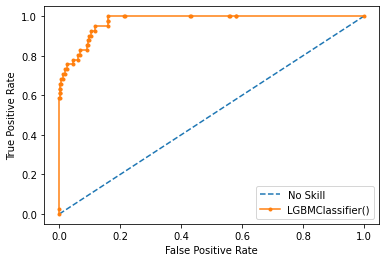

			Accuracy: 0.9871125267164109
			Precision: [0.99188227 0.98240771]
			Recall: [0.98222591 0.9920128 ]
			NS_AUC: 0.5088794514971733
			AUC_LOO: 0.9711069418386492
			Best Threshold=0.035559, G-Mean=0.917
		Dataset: 2year
[(0.0, 96.06815203145477), (1.0, 3.9318479685452163)]
Counter({0.0: 1466, 1.0: 60})


100%|===================| 16545/16614 [02:57<00:00]        

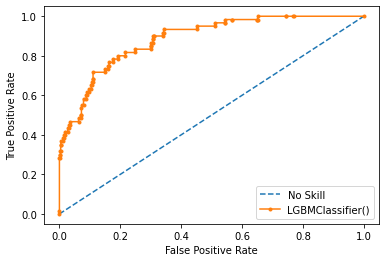

			Accuracy: 0.9805585031840728
			Precision: [0.98353981 0.97764878]
			Recall: [0.97749029 0.9836356 ]
			NS_AUC: 0.5123292517983369
			AUC_LOO: 0.8809538426557527
			Best Threshold=0.067562, G-Mean=0.804
		Dataset: 3year
[(0.0, 95.30456852791879), (1.0, 4.695431472081219)]
Counter({0.0: 1502, 1.0: 74})


100%|===================| 16962/17012 [02:54<00:00]        

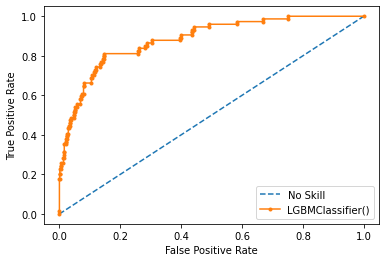

			Accuracy: 0.9757230669138464
			Precision: [0.97981166 0.97168434]
			Recall: [0.97142992 0.98004187]
			NS_AUC: 0.5046196291020729
			AUC_LOO: 0.8786455896642315
			Best Threshold=0.102987, G-Mean=0.832
		Dataset: 4year
[(0.0, 94.75833900612662), (1.0, 5.241660993873383)]
Counter({0.0: 1392, 1.0: 77})


 99%|===================| 15675/15770 [02:40<00:00]        

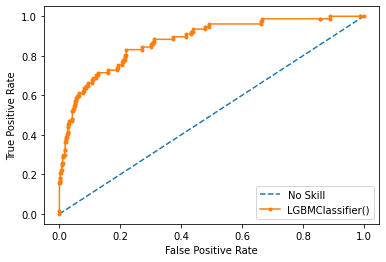

			Accuracy: 0.9723525681674066
			Precision: [0.98091018 0.96410992]
			Recall: [0.96348076 0.98120767]
			NS_AUC: 0.49481200818432747
			AUC_LOO: 0.8709480892670547
			Best Threshold=0.075340, G-Mean=0.805
		Dataset: 5year
[(0.0, 93.01014656144307), (1.0, 6.989853438556934)]
Counter({0.0: 825, 1.0: 62})


 99%|===================| 9282/9350 [01:40<00:00]        

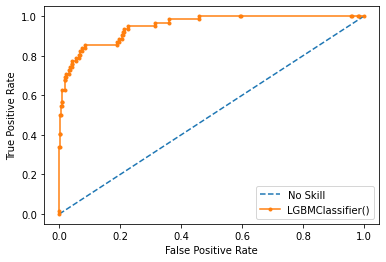

			Accuracy: 0.973048128342246
			Precision: [0.98251531 0.96374805]
			Recall: [0.9634045  0.98291953]
			NS_AUC: 0.49400921553554433
			AUC_LOO: 0.9472336265884653
			Best Threshold=0.184594, G-Mean=0.884
------------------------------------------------------------------------------------------------------------------------ 
 Model: XGB Classifier
	Imputer Technique: Mean
		Dataset: 1year
[(0.0, 96.11374407582939), (1.0, 3.886255924170616)]
Counter({0.0: 1014, 1.0: 41})


 99%|===================| 11426/11484 [01:41<00:00]        

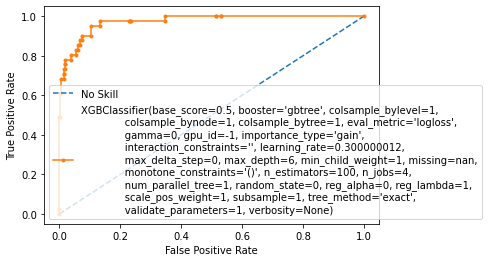

			Accuracy: 0.9892022089105771
			Precision: [0.99278997 0.98566928]
			Recall: [0.98552129 0.99287286]
			NS_AUC: 0.4967290628123225
			AUC_LOO: 0.9721027565305238
			Best Threshold=0.020953, G-Mean=0.923
		Dataset: 2year
[(0.0, 96.06815203145477), (1.0, 3.9318479685452163)]
Counter({0.0: 1466, 1.0: 60})


100%|===================| 16547/16614 [02:43<00:00]        

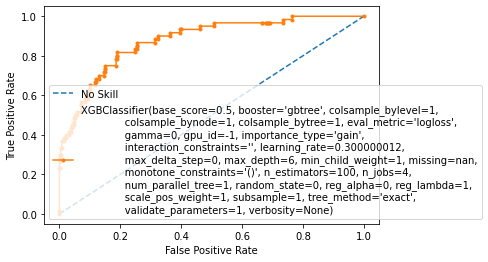

			Accuracy: 0.9862766448355949
			Precision: [0.98802302 0.98456755]
			Recall: [0.98443229 0.98810767]
			NS_AUC: 0.4980014652779514
			AUC_LOO: 0.8684868121873578
			Best Threshold=0.020138, G-Mean=0.814
		Dataset: 3year
[(0.0, 95.30456852791879), (1.0, 4.695431472081219)]
Counter({0.0: 1502, 1.0: 74})


100%|===================| 16961/17012 [02:42<00:00]        

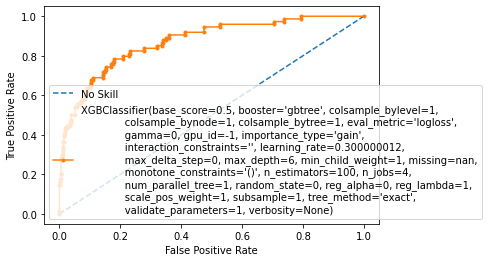

			Accuracy: 0.9817188312764111
			Precision: [0.98542815 0.97807852]
			Recall: [0.97789017 0.98554581]
			NS_AUC: 0.5104040187523337
			AUC_LOO: 0.86299798466909
			Best Threshold=0.028011, G-Mean=0.802
		Dataset: 4year
[(0.0, 94.75833900612662), (1.0, 5.241660993873383)]
Counter({0.0: 1392, 1.0: 77})


 99%|===================| 15656/15770 [02:14<00:00]        

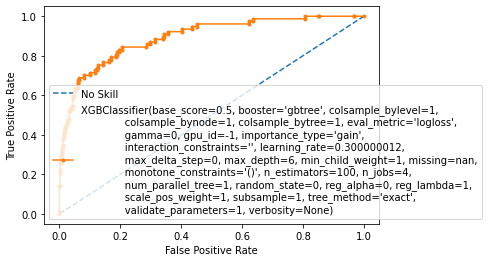

			Accuracy: 0.979137603043754
			Precision: [0.9853805 0.9730985]
			Recall: [0.97273033 0.9855202 ]
			NS_AUC: 0.4840551991712725
			AUC_LOO: 0.8858663606508435
			Best Threshold=0.025430, G-Mean=0.818
		Dataset: 5year
[(0.0, 93.01014656144307), (1.0, 6.989853438556934)]
Counter({0.0: 825, 1.0: 62})


 99%|===================| 9295/9350 [01:14<00:00]        

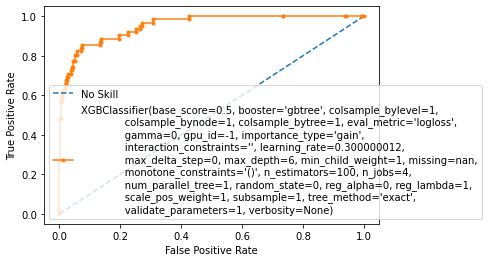

			Accuracy: 0.9751871657754011
			Precision: [0.9840734  0.96649842]
			Recall: [0.96607106 0.98440881]
			NS_AUC: 0.48874940515411086
			AUC_LOO: 0.9497986314760507
			Best Threshold=0.138811, G-Mean=0.889
------------------------------------------------------------------------------------------------------------------------ 
 Model: LR Classifier
	Imputer Technique: Mean
		Dataset: 1year
[(0.0, 96.11374407582939), (1.0, 3.886255924170616)]
Counter({0.0: 1014, 1.0: 41})


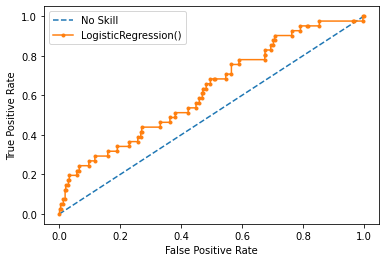

			Accuracy: 0.610849365708036
			Precision: [0.58922227 0.64817865]
			Recall: [0.73498731 0.48725865]
			NS_AUC: 0.5113856257993177
			AUC_LOO: 0.625730023572425
			Best Threshold=0.483773, G-Mean=0.587
		Dataset: 2year
[(0.0, 96.06815203145477), (1.0, 3.9318479685452163)]
Counter({0.0: 1466, 1.0: 60})


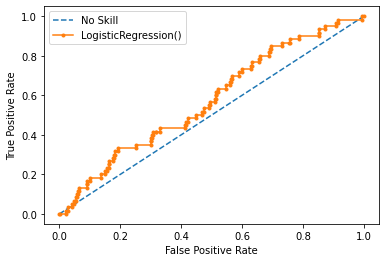

			Accuracy: 0.56301817391892
			Precision: [0.54425388 0.61582145]
			Recall: [0.7895501  0.33741405]
			NS_AUC: 0.5086439436205126
			AUC_LOO: 0.5775829922692133
			Best Threshold=0.492968, G-Mean=0.551
		Dataset: 3year
[(0.0, 95.30456852791879), (1.0, 4.695431472081219)]
Counter({0.0: 1502, 1.0: 74})


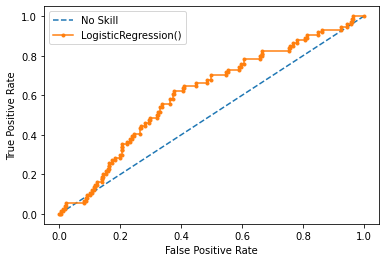

			Accuracy: 0.5691872838279604
			Precision: [0.56811418 0.6043178 ]
			Recall: [0.68900266 0.44590721]
			NS_AUC: 0.4854043644811993
			AUC_LOO: 0.5826375643286429
			Best Threshold=0.500645, G-Mean=0.622
		Dataset: 4year
[(0.0, 94.75833900612662), (1.0, 5.241660993873383)]
Counter({0.0: 1392, 1.0: 77})


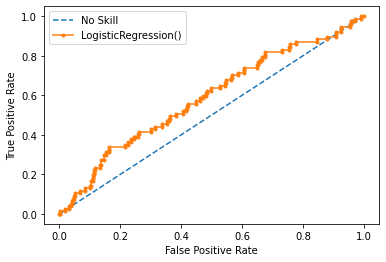

			Accuracy: 0.6076727964489537
			Precision: [0.59154488 0.63414765]
			Recall: [0.69922682 0.51633517]
			NS_AUC: 0.5033220680869135
			AUC_LOO: 0.5856247201074788
			Best Threshold=0.493198, G-Mean=0.568
		Dataset: 5year
[(0.0, 93.01014656144307), (1.0, 6.989853438556934)]
Counter({0.0: 825, 1.0: 62})


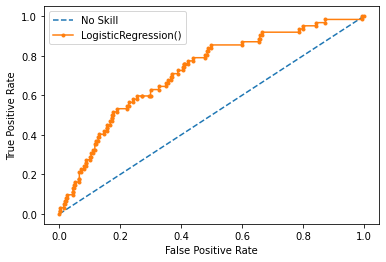

			Accuracy: 0.6775401069518716
			Precision: [0.68300474 0.67204992]
			Recall: [0.66384767 0.69077144]
			NS_AUC: 0.5031366681309026
			AUC_LOO: 0.7156187683284457
			Best Threshold=0.493508, G-Mean=0.670
------------------------------------------------------------------------------------------------------------------------ 
 Model: AdaBoost Classifier
	Imputer Technique: Mean
		Dataset: 1year
[(0.0, 96.11374407582939), (1.0, 3.886255924170616)]
Counter({0.0: 1014, 1.0: 41})


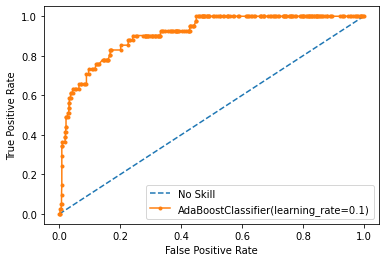

			Accuracy: 0.8505744881598328
			Precision: [0.84916081 0.851978  ]
			Recall: [0.85249572 0.84886261]
			NS_AUC: 0.5062677140956355
			AUC_LOO: 0.9101505748785298
			Best Threshold=0.497355, G-Mean=0.831
		Dataset: 2year
[(0.0, 96.06815203145477), (1.0, 3.9318479685452163)]
Counter({0.0: 1466, 1.0: 60})


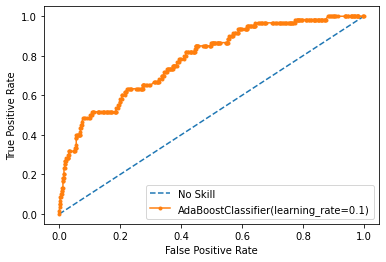

			Accuracy: 0.7966777624724545
			Precision: [0.77227079 0.82593917]
			Recall: [0.84159151 0.75189304]
			NS_AUC: 0.5162175673123387
			AUC_LOO: 0.7829081400636653
			Best Threshold=0.489733, G-Mean=0.702
		Dataset: 3year
[(0.0, 95.30456852791879), (1.0, 4.695431472081219)]
Counter({0.0: 1502, 1.0: 74})


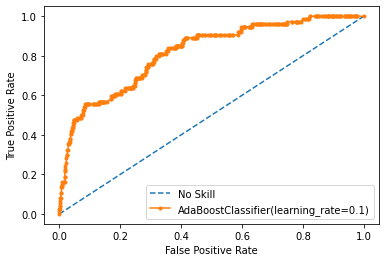

			Accuracy: 0.8034911444288791
			Precision: [0.78827146 0.82080244]
			Recall: [0.83029913 0.77694308]
			NS_AUC: 0.49720962232578725
			AUC_LOO: 0.8179607370353041
			Best Threshold=0.472568, G-Mean=0.739
		Dataset: 4year
[(0.0, 94.75833900612662), (1.0, 5.241660993873383)]
Counter({0.0: 1392, 1.0: 77})


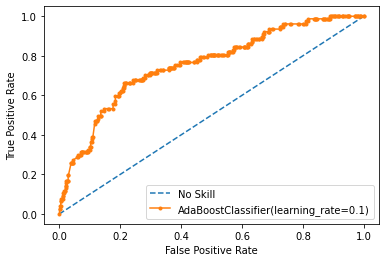

			Accuracy: 0.7928979074191502
			Precision: [0.7915902  0.79433464]
			Recall: [0.7953396  0.79056212]
			NS_AUC: 0.4943648299114008
			AUC_LOO: 0.756399276011345
			Best Threshold=0.496248, G-Mean=0.722
		Dataset: 5year
[(0.0, 93.01014656144307), (1.0, 6.989853438556934)]
Counter({0.0: 825, 1.0: 62})


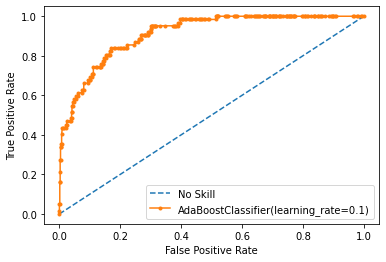

			Accuracy: 0.8459893048128342
			Precision: [0.82810711 0.86572736]
			Recall: [0.87315645 0.81907278]
			NS_AUC: 0.4974822003807013
			AUC_LOO: 0.9121368523949169
			Best Threshold=0.487211, G-Mean=0.835
------------------------------------------------------------------------------------------------------------------------ 
 Model: RF Classifier
	Imputer Technique: Mean
		Dataset: 1year
[(0.0, 96.11374407582939), (1.0, 3.886255924170616)]
Counter({0.0: 1014, 1.0: 41})


100%|===================| 22877/22968 [03:26<00:00]        

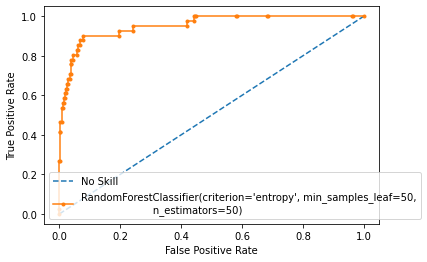

			Accuracy: 0.9423541386356085
			Precision: [0.94613627 0.93862857]
			Recall: [0.93792933 0.94682865]
			NS_AUC: 0.499922536430661
			AUC_LOO: 0.9509164381584645
			Best Threshold=0.455805, G-Mean=0.913
		Dataset: 2year
[(0.0, 96.06815203145477), (1.0, 3.9318479685452163)]
Counter({0.0: 1466, 1.0: 60})


100%|===================| 33169/33228 [06:35<00:00]        

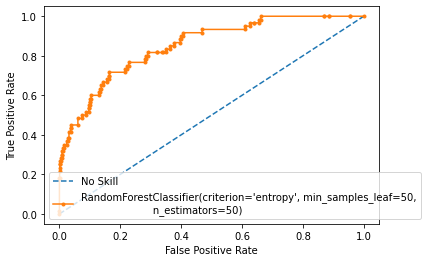

			Accuracy: 0.9202480187074814
			Precision: [0.92197527 0.91858789]
			Recall: [0.91826055 0.92226886]
			NS_AUC: 0.494315975843577
			AUC_LOO: 0.8476853115052296
			Best Threshold=0.406357, G-Mean=0.774
		Dataset: 3year
[(0.0, 95.30456852791879), (1.0, 4.695431472081219)]
Counter({0.0: 1502, 1.0: 74})


100%|===================| 34019/34024 [06:28<00:00]        

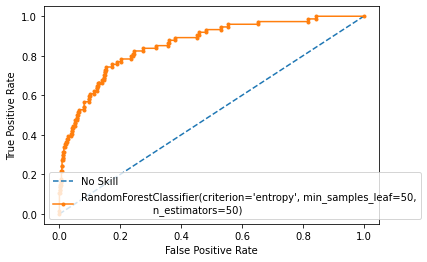

			Accuracy: 0.9090054717083156
			Precision: [0.91517845 0.90300372]
			Recall: [0.90165065 0.91645539]
			NS_AUC: 0.48846268202624776
			AUC_LOO: 0.8562880123798899
			Best Threshold=0.415511, G-Mean=0.793
		Dataset: 4year
[(0.0, 94.75833900612662), (1.0, 5.241660993873383)]
Counter({0.0: 1392, 1.0: 77})


100%|===================| 31523/31540 [06:04<00:00]        

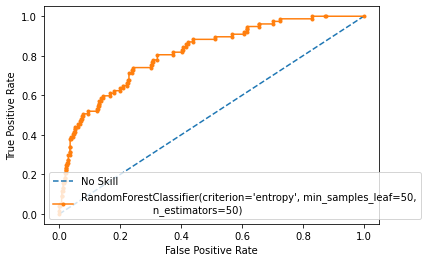

			Accuracy: 0.8934051997463539
			Precision: [0.91602058 0.87315983]
			Recall: [0.86618907 0.92069108]
			NS_AUC: 0.4978678604289051
			AUC_LOO: 0.8130588520674727
			Best Threshold=0.391992, G-Mean=0.749
		Dataset: 5year
[(0.0, 93.01014656144307), (1.0, 6.989853438556934)]
Counter({0.0: 825, 1.0: 62})


100%|===================| 18697/18700 [02:25<00:00]        

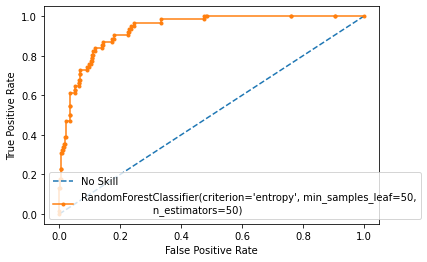

			Accuracy: 0.8978609625668449
			Precision: [0.90069501 0.89507819]
			Recall: [0.89473825 0.9011121 ]
			NS_AUC: 0.4993330862435025
			AUC_LOO: 0.9315698924731182
			Best Threshold=0.441095, G-Mean=0.864


In [24]:
results = perform_data_modeling(models_dictionary, imputed_oversampled_dataframes_dictionary, imputed_dataframes_dictionary_test, calc_shap=True, model_names=[], verbose=True, k_folds=5)

In [25]:
#access results dictionary
results['LGBM']['Mean']

OrderedDict([('1year',
              OrderedDict([('Accuracy', 0.9871125267164109),
                           ('Accuracy_LOO', 0.9732701421800949),
                           ('Precisions', array([0.99188227, 0.98240771])),
                           ('Precisions_LOO', array([0.99188227, 0.98240771])),
                           ('Recalls', array([0.98222591, 0.9920128 ])),
                           ('Recalls_LOO', array([0.98222591, 0.9920128 ])),
                           ('f1-score', array([0.98702868, 0.98718485])),
                           ('f1-score_LOO', array([0.98605872, 0.67644097])),
                           ('TN', 1128.0),
                           ('FP', 20.4),
                           ('FN', 9.2),
                           ('TP', 1139.2),
                           ('NS_AUC', 0.5088794514971733),
                           ('AUC', 0.9989751050297132),
                           ('AUC_LOO', 0.9711069418386492),
                           ('CM',
                 

In [26]:
# model -> imputer -> year
#rank mean accuracy
def perform_model_ranking_accuracy(models, imputers, results):
    column_headers = ['-'] + list(imputers.keys())
    rows = []
    for model_name, model_details in results.items():
        row = [model_name]
        for imputer_name, imputer_details in model_details.items():
            mean_accuracy = 0
            for year, metrics in imputer_details.items():
                mean_accuracy += metrics['Accuracy_LOO']
            mean_accuracy = mean_accuracy/len(imputer_details)
            row.append(mean_accuracy)
        rows.append(row)
    results_df = pd.DataFrame(data=rows, columns = column_headers)
    return results_df

#rank mean AUC
def perform_model_ranking_auc(models, imputers, results):
    column_headers = ['-'] + list(imputers.keys())
    rows = []
    for model_name, model_details in results.items():
        row = [model_name]
        for imputer_name, imputer_details in model_details.items():
            mean_accuracy = 0
            for year, metrics in imputer_details.items():
                mean_accuracy += metrics['AUC_LOO']
            mean_accuracy = mean_accuracy/len(imputer_details)
            row.append(mean_accuracy)
        rows.append(row)
    results_df = pd.DataFrame(data=rows, columns = column_headers)
    return results_df

#rank mean Train Time
def perform_model_ranking_train_time(models, imputers, results):
    column_headers = ['-'] + list(imputers.keys())
    rows = []
    for model_name, model_details in results.items():
        row = [model_name]
        for imputer_name, imputer_details in model_details.items():
            mean_train_time = 0
            for year, metrics in imputer_details.items():
                mean_train_time += metrics['train_time']
            mean_train_time = mean_train_time/len(imputer_details)
            row.append(mean_train_time)
        rows.append(row)
    results_df = pd.DataFrame(data=rows, columns = column_headers)
    return results_df


#rank mean f1-score
def perform_model_ranking_f1(models, imputers, results):
    column_headers = ['-'] + list(imputers.keys())
    rows = []
    for model_name, model_details in results.items():
        row = [model_name]
        for imputer_name, imputer_details in model_details.items():
            mean_f1_score_loo = 0
            for year, metrics in imputer_details.items():
                mean_f1_score_loo += metrics['f1-score_LOO'][1]
            mean_f1_score_loo = mean_f1_score_loo/len(imputer_details)
            row.append(mean_f1_score_loo)
        rows.append(row)
    results_df = pd.DataFrame(data=rows, columns = column_headers)
    return results_df

#rank mean precsision_LOO
def perform_model_ranking_precision(models, imputers, results):
    column_headers = ['-'] + list(imputers.keys())
    rows = []
    for model_name, model_details in results.items():
        row = [model_name]
        for imputer_name, imputer_details in model_details.items():
            mean_f1_score_loo = 0
            for year, metrics in imputer_details.items():
                mean_f1_score_loo += metrics['Precisions_LOO'][1]
            mean_f1_score_loo = mean_f1_score_loo/len(imputer_details)
            row.append(mean_f1_score_loo)
        rows.append(row)
    results_df = pd.DataFrame(data=rows, columns = column_headers)
    return results_df

#rank mean precsision_LOO
def perform_model_ranking_recall(models, imputers, results):
    column_headers = ['-'] + list(imputers.keys())
    rows = []
    for model_name, model_details in results.items():
        row = [model_name]
        for imputer_name, imputer_details in model_details.items():
            mean_f1_score_loo = 0
            for year, metrics in imputer_details.items():
                mean_f1_score_loo += metrics['Recalls_LOO'][1]
            mean_f1_score_loo = mean_f1_score_loo/len(imputer_details)
            row.append(mean_f1_score_loo)
        rows.append(row)
    results_df = pd.DataFrame(data=rows, columns = column_headers)
    return results_df

In [200]:
# print Accuracy
perform_model_ranking_accuracy(models_dictionary, imputed_oversampled_dataframes_dictionary, results).sort_values(by=['Mean'], ascending = False)

,-,Mean
1,XGB,0.957081
0,LGBM,0.952224
4,RF,0.895096
3,AdaBoost,0.835040
2,LR,0.702619


In [27]:
#print AUC
perform_model_ranking_auc(models_dictionary, imputed_oversampled_dataframes_dictionary, results).sort_values(by=['Mean'], ascending = False)

,-,Mean
0,LGBM,0.909778
1,XGB,0.907851
4,RF,0.879904
3,AdaBoost,0.835911
2,LR,0.617439


In [133]:
#print mean train_time
perform_model_ranking_train_time(models_dictionary, imputed_oversampled_dataframes_dictionary, results).sort_values(by=['Mean'], ascending = True)

,-,Mean
2,LR,0.206959
0,LGBM,0.780548
4,RF,3.939293
3,AdaBoost,4.753810
1,XGB,7.933486


In [134]:
#print f1-score
perform_model_ranking_f1(models_dictionary, imputed_oversampled_dataframes_dictionary, results).sort_values(by=['Mean'], ascending = False)

,-,Mean
1,XGB,0.533182
0,LGBM,0.520362
4,RF,0.380186
3,AdaBoost,0.278401
2,LR,0.128992


In [135]:
#print precision
perform_model_ranking_precision(models_dictionary, imputed_oversampled_dataframes_dictionary, results).sort_values(by=['Mean'], ascending = False)

,-,Mean
1,XGB,0.977582
0,LGBM,0.971920
4,RF,0.906549
3,AdaBoost,0.831756
2,LR,0.634903


In [136]:
#print recall
perform_model_ranking_recall(models_dictionary, imputed_oversampled_dataframes_dictionary, results).sort_values(by=['Mean'], ascending = False)

,-,Mean
1,XGB,0.987291
0,LGBM,0.983963
4,RF,0.922117
3,AdaBoost,0.797467
2,LR,0.495537


In [125]:
def display_cm(cm):
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['survive', 'bankrupt']); ax.yaxis.set_ticklabels(['survive', 'bankrupt']);

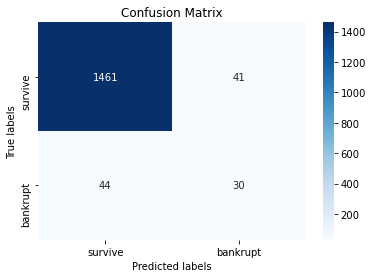

In [216]:
display_cm(results['LGBM']['Mean']['3year']['CM_LOO_DEFAULT'])

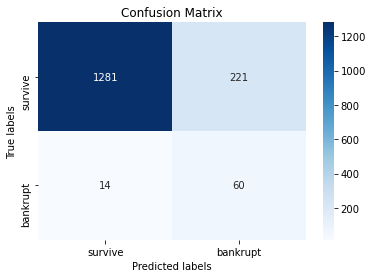

In [214]:
display_cm(results['LGBM']['Mean']['3year']['CM_LOO_BEST'])

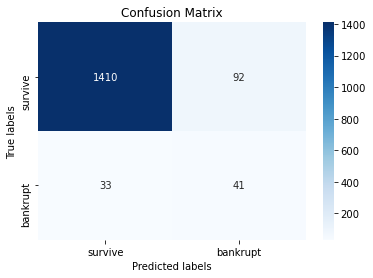

In [215]:
display_cm(results['LGBM']['Mean']['3year']['CM_LOO_CUSTOM'])

In [143]:
def display_importances(feature_importance_df, col, topk=10):
    best_features = feature_importance_df[['feature', f'{col}']]\
                        .groupby('feature')[f'{col}']\
                        .agg(['mean', 'std'])\
                        .sort_values(by='mean', ascending=False)\
                        .head(topk)\
                        .reset_index()

    best_features.columns = ['feature', f'mean {col} values', 'err']
    plt.figure(figsize=(8, 10))
    sns.barplot(x=f'mean {col} values', y='feature', xerr=best_features['err'], data=best_features)
    plt.show()
a =5


In [ ]:
#CatBoost
tmp_CB_1 = results['CatBoost']['Mean']['1year']['importance']
tmp_CB_2 = results['CatBoost']['Mean']['2year']['importance']
tmp_CB_3 = results['CatBoost']['Mean']['3year']['importance']
tmp_CB_4 = results['CatBoost']['Mean']['4year']['importance']
tmp_CB_5 = results['CatBoost']['Mean']['5year']['importance']
display_importances(tmp_CB_1, col='shap_values', topk=a)
display_importances(tmp_CB_2, col='shap_values', topk=a)
display_importances(tmp_CB_3, col='shap_values', topk=a)
display_importances(tmp_CB_4, col='shap_values', topk=a)
display_importances(tmp_CB_5, col='shap_values', topk=a)

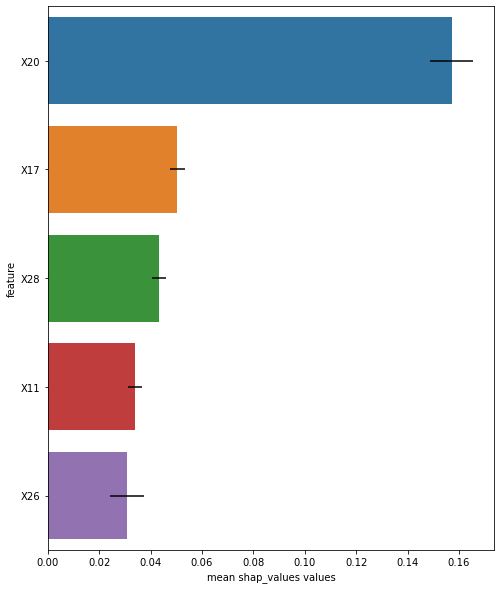

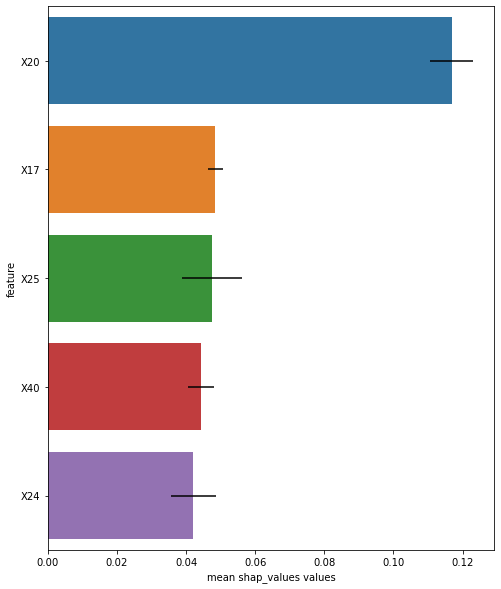

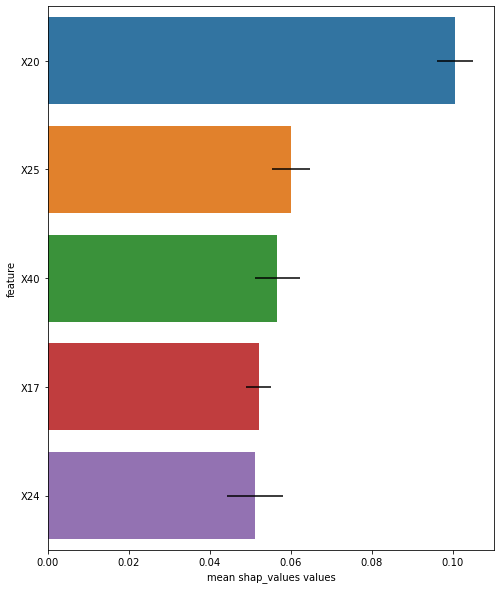

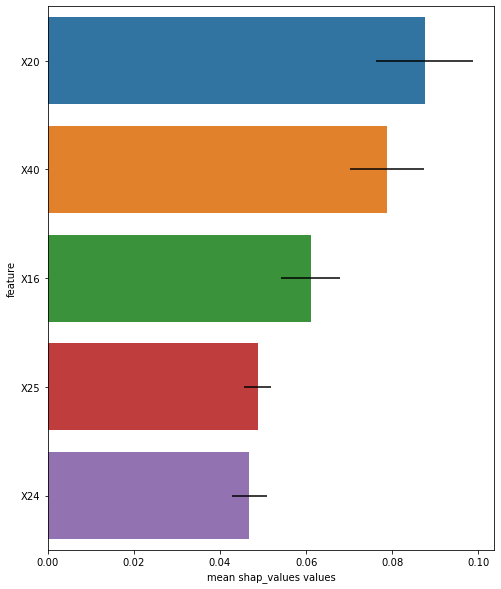

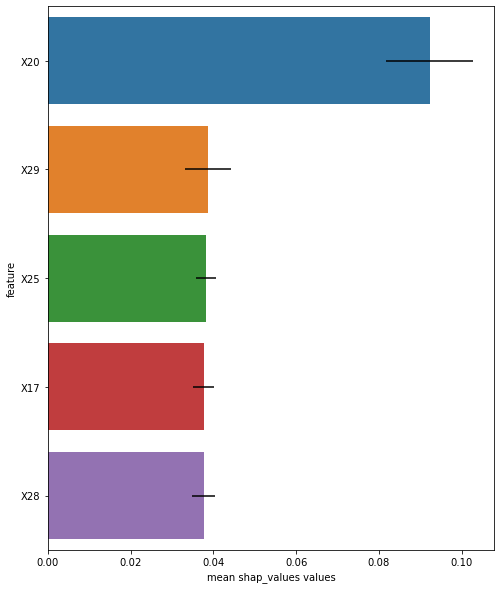

In [212]:
#XGB
tmp_XGB_1 = results['XGB']['Mean']['1year']['importance']
tmp_XGB_2 = results['XGB']['Mean']['2year']['importance']
tmp_XGB_3 = results['XGB']['Mean']['3year']['importance']
tmp_XGB_4 = results['XGB']['Mean']['4year']['importance']
tmp_XGB_5 = results['XGB']['Mean']['5year']['importance']
display_importances(tmp_XGB_1, col='shap_values', topk=a)
display_importances(tmp_XGB_2, col='shap_values', topk=a)
display_importances(tmp_XGB_3, col='shap_values', topk=a)
display_importances(tmp_XGB_4, col='shap_values', topk=a)
display_importances(tmp_XGB_5, col='shap_values', topk=a)

In [ ]:
tmp_LGBM_1 = results['LGBM']['Mean']['1year']['importance']
display_importances(tmp_LGBM_1, col='shap_values', topk=a)

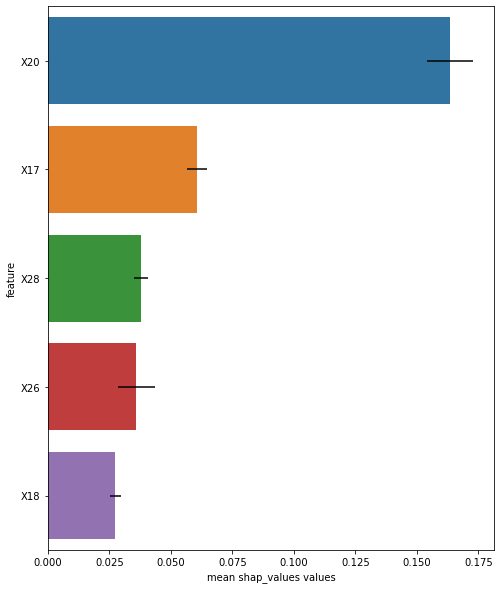

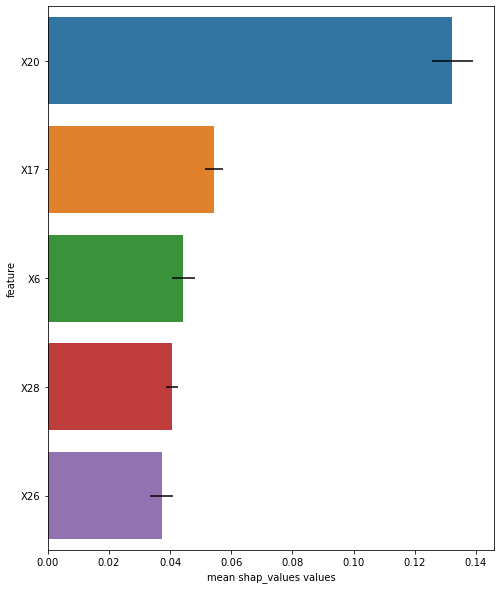

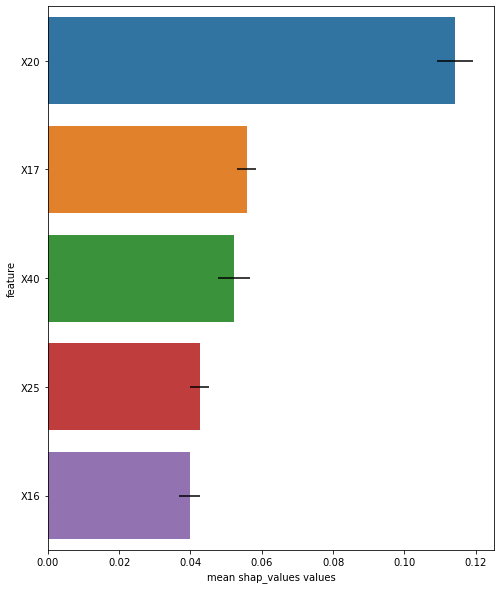

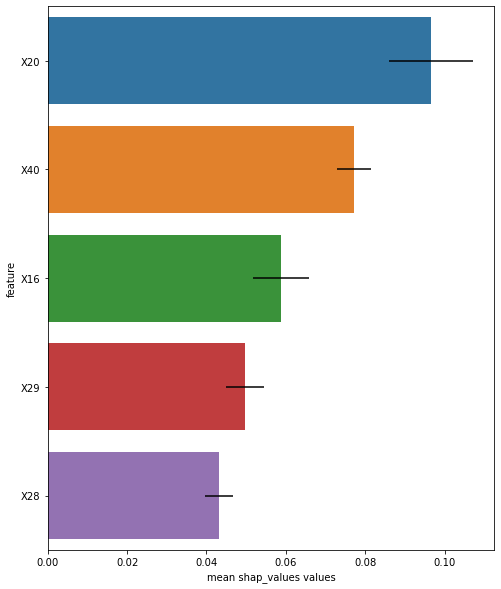

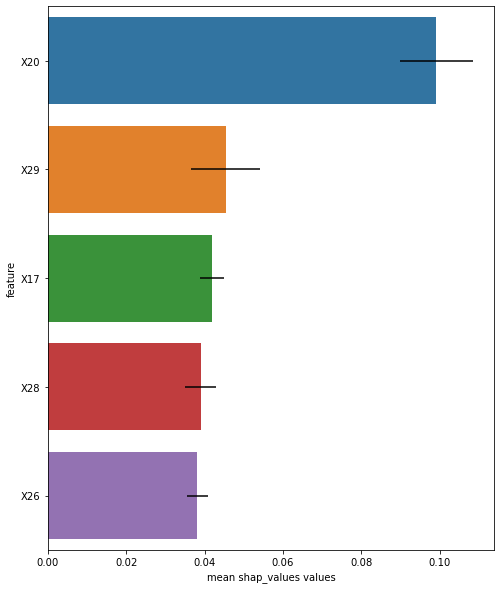

In [144]:
#LGBM
tmp_LGBM_1 = results['LGBM']['Mean']['1year']['importance']
tmp_LGBM_2 = results['LGBM']['Mean']['2year']['importance']
tmp_LGBM_3 = results['LGBM']['Mean']['3year']['importance']
tmp_LGBM_4 = results['LGBM']['Mean']['4year']['importance']
tmp_LGBM_5 = results['LGBM']['Mean']['5year']['importance']
display_importances(tmp_LGBM_1, col='shap_values', topk=a)
display_importances(tmp_LGBM_2, col='shap_values', topk=a)
display_importances(tmp_LGBM_3, col='shap_values', topk=a)
display_importances(tmp_LGBM_4, col='shap_values', topk=a)
display_importances(tmp_LGBM_5, col='shap_values', topk=a)

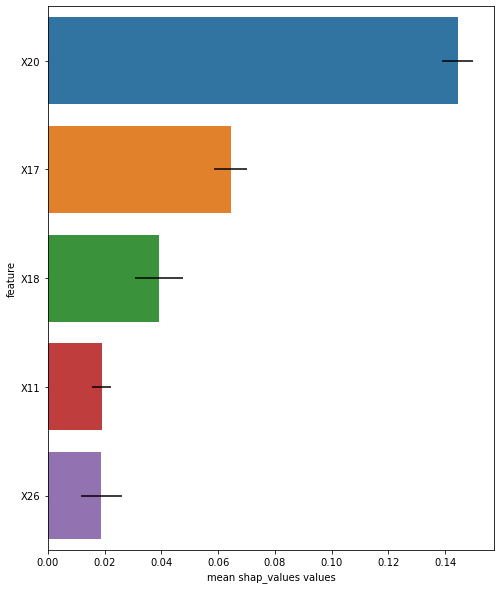

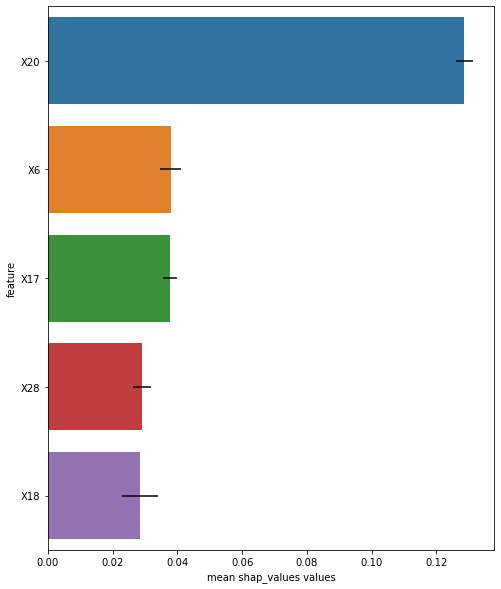

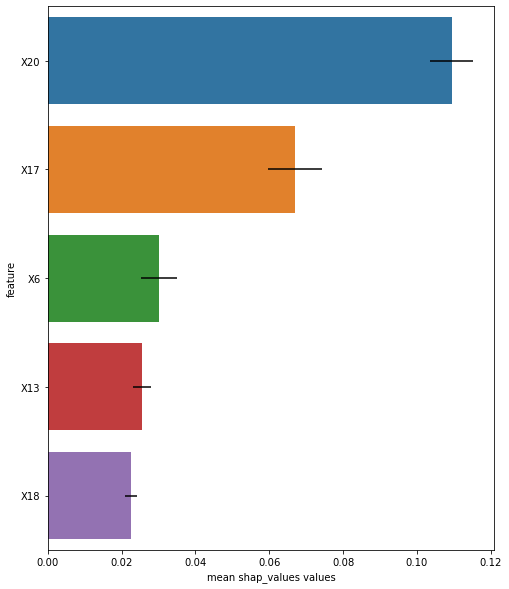

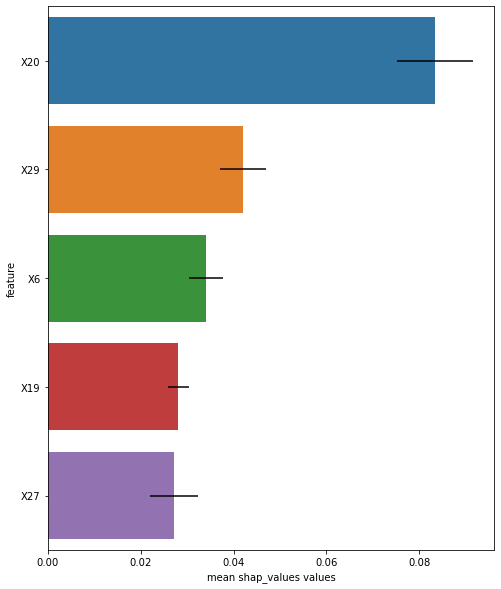

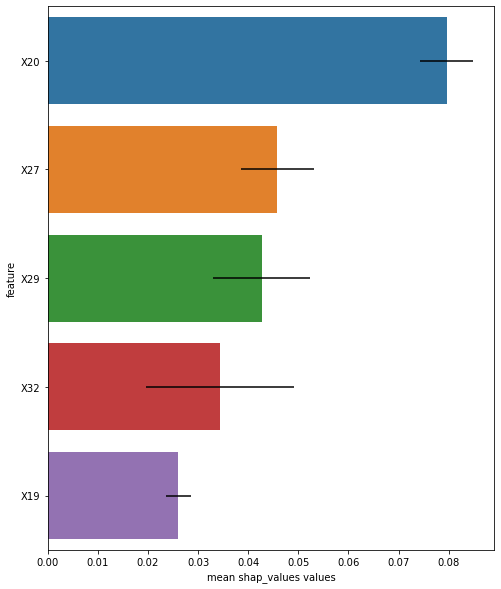

In [217]:
#RF
tmp_RF_1 = results['RF']['Mean']['1year']['importance']
tmp_RF_2 = results['RF']['Mean']['2year']['importance']
tmp_RF_3 = results['RF']['Mean']['3year']['importance']
tmp_RF_4 = results['RF']['Mean']['4year']['importance']
tmp_RF_5 = results['RF']['Mean']['5year']['importance']
display_importances(tmp_RF_1, col='shap_values', topk=a)
display_importances(tmp_RF_2, col='shap_values', topk=a)
display_importances(tmp_RF_3, col='shap_values', topk=a)
display_importances(tmp_RF_4, col='shap_values', topk=a)
display_importances(tmp_RF_5, col='shap_values', topk=a)

In [ ]:
#check feature importance
df_shap_xgb = results['XGB']['Mean']['4year']['importance']
df_shap_meanfold = df_shap_xgb.groupby('feature').mean()
df_shap_meanfold.sort_values(by=['shap_values'], ascending = False).head(5)

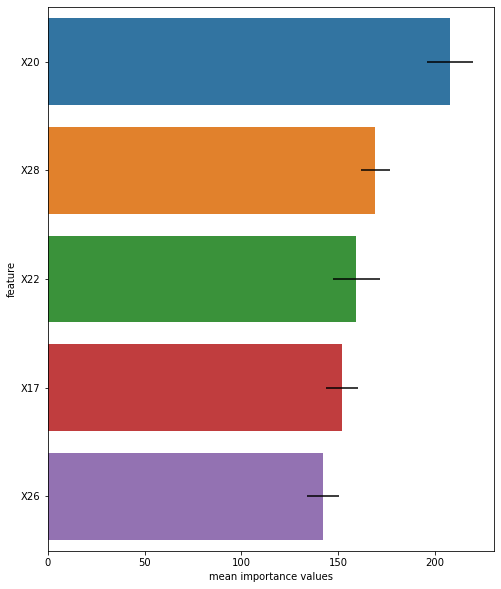

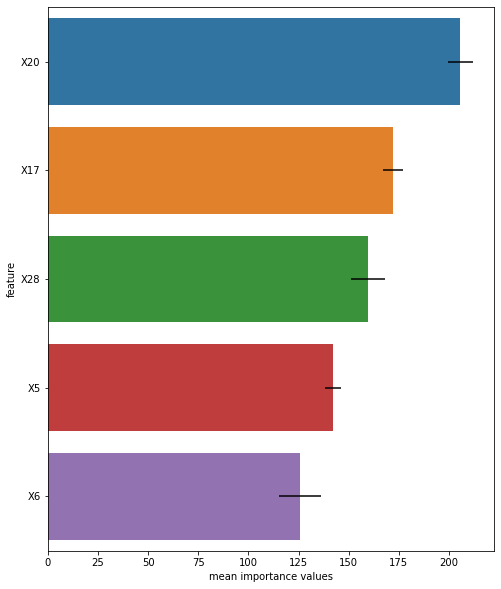

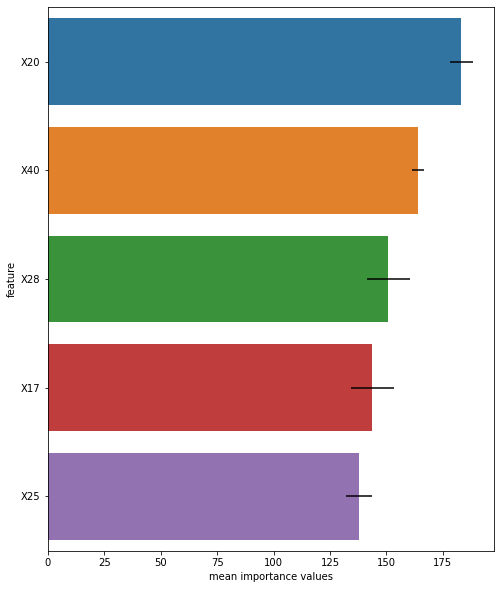

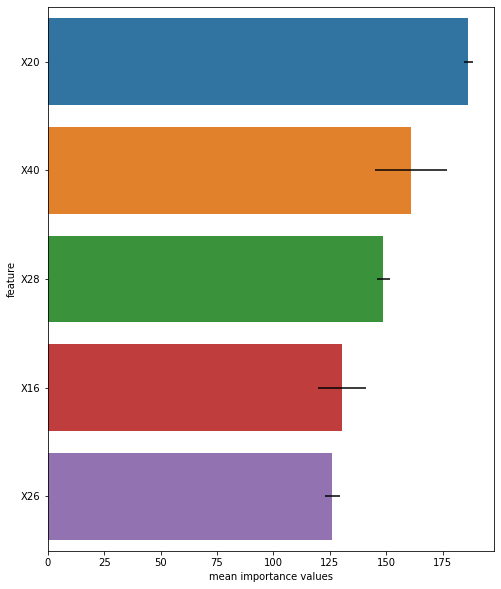

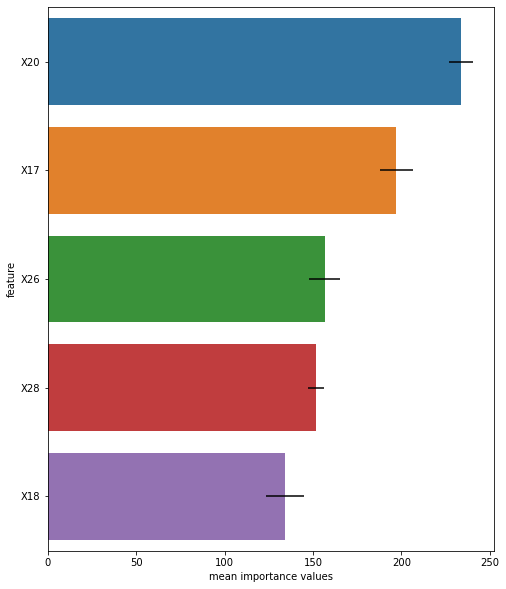

In [219]:
tmp_RF_1 = results['LGBM']['Mean']['1year']['importance']
tmp_RF_2 = results['LGBM']['Mean']['2year']['importance']
tmp_RF_3 = results['LGBM']['Mean']['3year']['importance']
tmp_RF_4 = results['LGBM']['Mean']['4year']['importance']
tmp_RF_5 = results['LGBM']['Mean']['5year']['importance']
display_importances(tmp_RF_1, col='importance', topk=a)
display_importances(tmp_RF_2, col='importance', topk=a)
display_importances(tmp_RF_3, col='importance', topk=a)
display_importances(tmp_RF_4, col='importance', topk=a)
display_importances(tmp_RF_5, col='importance', topk=a)

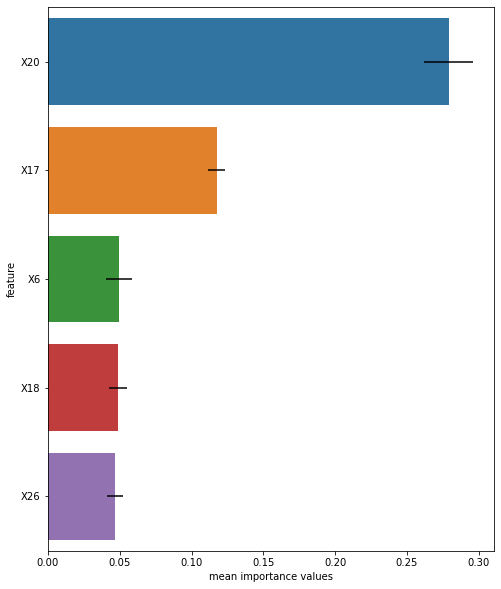

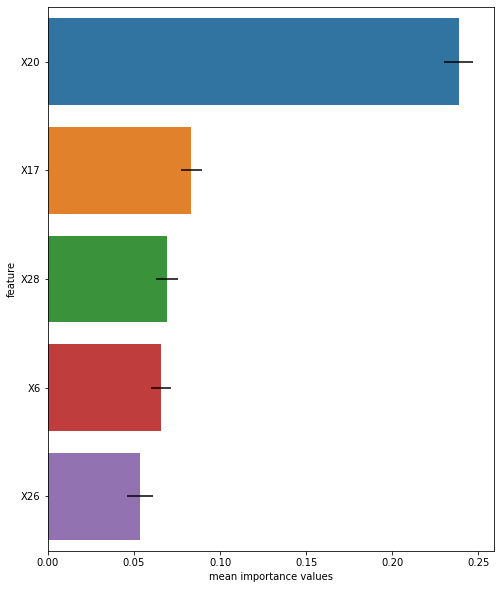

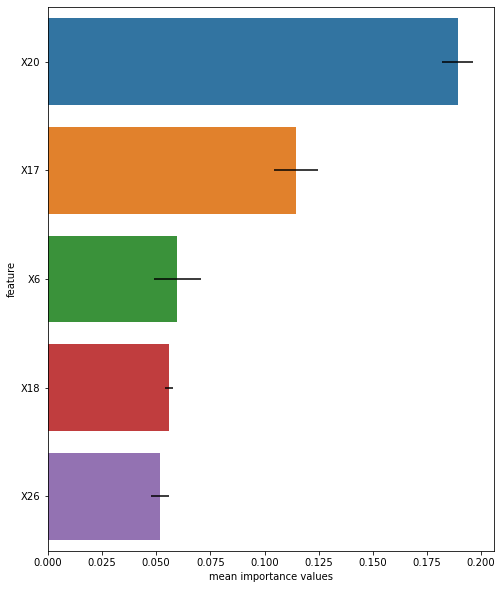

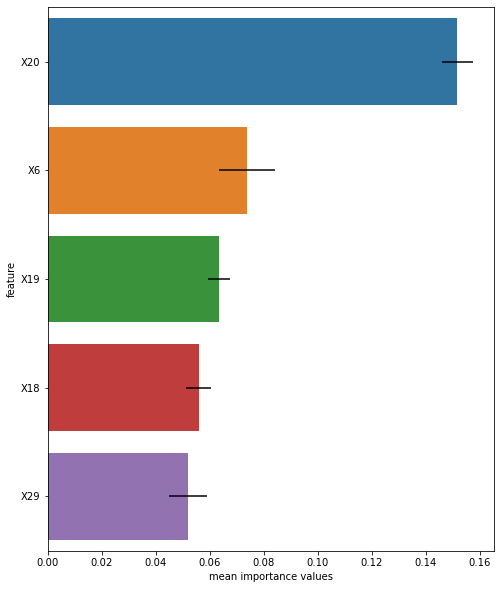

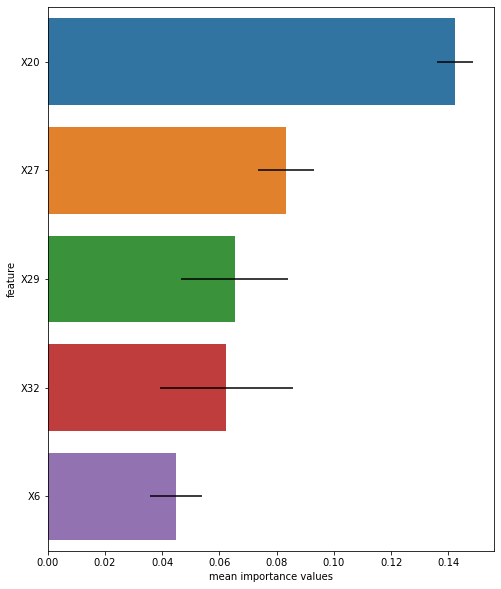

In [161]:
tmp_RF_1 = results['RF']['Mean']['1year']['importance']
tmp_RF_2 = results['RF']['Mean']['2year']['importance']
tmp_RF_3 = results['RF']['Mean']['3year']['importance']
tmp_RF_4 = results['RF']['Mean']['4year']['importance']
tmp_RF_5 = results['RF']['Mean']['5year']['importance']
display_importances(tmp_RF_1, col='importance', topk=a)
display_importances(tmp_RF_2, col='importance', topk=a)
display_importances(tmp_RF_3, col='importance', topk=a)
display_importances(tmp_RF_4, col='importance', topk=a)
display_importances(tmp_RF_5, col='importance', topk=a)

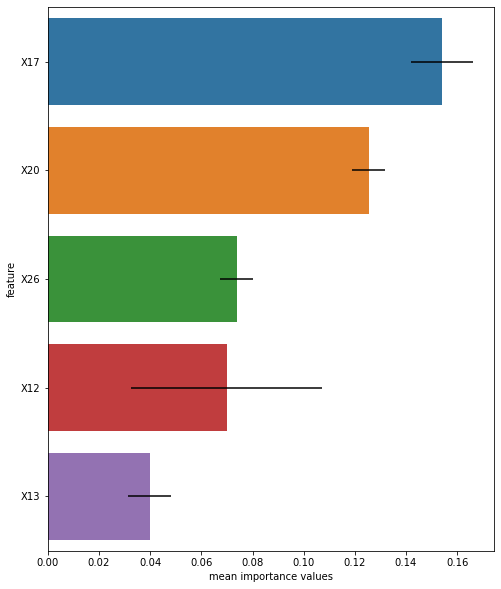

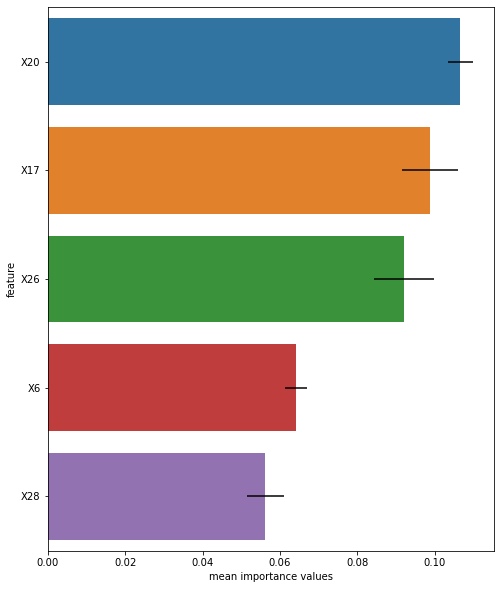

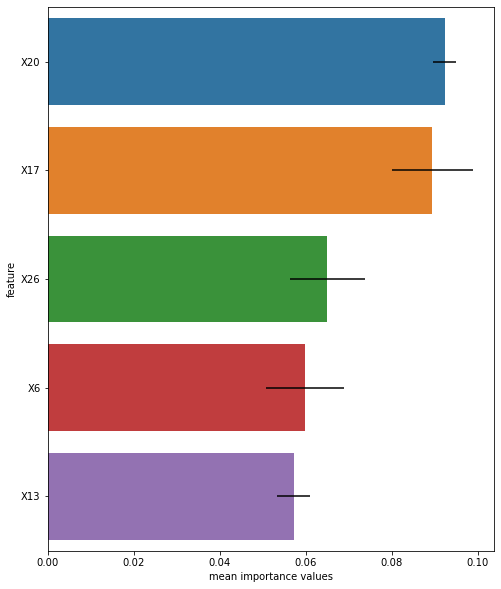

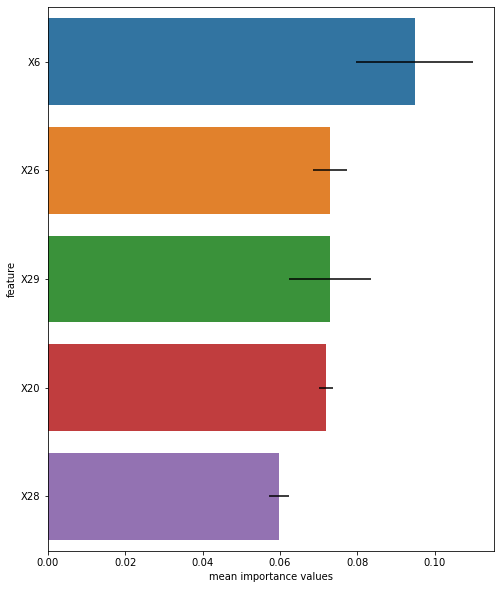

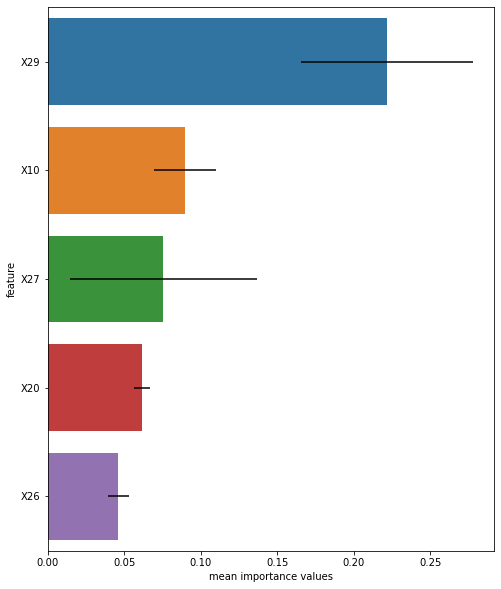

In [220]:
tmp_RF_1 = results['XGB']['Mean']['1year']['importance']
tmp_RF_2 = results['XGB']['Mean']['2year']['importance']
tmp_RF_3 = results['XGB']['Mean']['3year']['importance']
tmp_RF_4 = results['XGB']['Mean']['4year']['importance']
tmp_RF_5 = results['XGB']['Mean']['5year']['importance']
display_importances(tmp_RF_1, col='importance', topk=a)
display_importances(tmp_RF_2, col='importance', topk=a)
display_importances(tmp_RF_3, col='importance', topk=a)
display_importances(tmp_RF_4, col='importance', topk=a)
display_importances(tmp_RF_5, col='importance', topk=a)

In [154]:
df_shap_rf = results['RF']['Mean']['5year']['importance']

df_shap_meanfold = df_shap_ab.groupby('feature').mean()

df_shap_meanfold.sort_values(by=['importance'], ascending = False).head(5)

,importance,shap_values,fold
feature,,,
X20,0.142252,0.079585,3
X27,0.083173,0.045747,3
X29,0.065306,0.042696,3
X32,0.062361,0.034394,3
X6,0.044893,0.022171,3
